In [1]:
import torch._dynamo
torch._dynamo.disable()
torch._dynamo.config.suppress_errors = True

In [2]:
!pip install datasets -q

In [3]:
import pandas as pd
import numpy as np

LABEL = 'mistake_identification'
MODEL = "answerdotai/ModernBERT-large"
SEED = 42

train_df = pd.read_csv("data/mistake_identification_train.csv")
val_df = pd.read_csv("data/mistake_identification_val.csv")

full_df = pd.concat([train_df, val_df]).reset_index(drop=True)

In [4]:
import torch, random, numpy as np

def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

In [5]:
from collections import Counter
import torch

def get_weights(train_df, label):
  label_counts = Counter(train_df[label])
  total = sum(label_counts.values())
  weights = torch.tensor([total / label_counts.get(cls, 1) for cls in range(3)])
  return weights

In [6]:
alpha = torch.tensor([1.0, 1.0, 1.0])
weights = get_weights(train_df, LABEL)

In [7]:
import torch.nn.functional as F
import torch.nn as nn

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        logpt = F.log_softmax(inputs, dim=-1)
        pt = torch.exp(logpt)
        logpt = logpt.gather(1, targets.unsqueeze(1)).squeeze(1)
        pt = pt.gather(1, targets.unsqueeze(1)).squeeze(1)

        if self.alpha is not None:
            at = self.alpha.to(targets.device).gather(0, targets)
            logpt = logpt * at

        loss = -1 * (1 - pt) ** self.gamma * logpt

        if self.reduction == "mean":
            return loss.mean()
        elif self.reduction == "sum":
            return loss.sum()
        return loss

In [8]:
from transformers import Trainer

class CustomTrainer(Trainer):
    def __init__(self, *args, loss_type="cross_entropy", weights, alpha, gamma, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_type = loss_type
        self.weights = weights
        self.focal_loss = FocalLoss(alpha=alpha if loss_type == "focal" else None, gamma=gamma if loss_type =="focal" else None)

    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
      labels = inputs.pop("labels")
      outputs = model(**inputs)
      logits = outputs.logits

      if self.loss_type == "focal":
          loss = self.focal_loss(logits, labels)
      elif self.loss_type == "weighted":
          w = self.weights.to(logits.device)
          loss = F.cross_entropy(logits, labels, weight=w)
      else:
          loss = F.cross_entropy(logits, labels)

      return (loss, outputs) if return_outputs else loss

/usr/local/lib/python3.10/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
import pandas as pd
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL)

# Compute token lengths
token_lengths = full_df["response"].apply(lambda x: len(tokenizer.tokenize(x)))
token_lengths_context = full_df.apply(
    lambda row: len(tokenizer.tokenize(f"Student: {row['last_student_turn']} Tutor: {row['response']}")),
    axis=1
)
token_lengths_context_full = full_df.apply(
    lambda row: len(tokenizer.tokenize(f"Student: {row['conversation_history']} Tutor: {row['response']}")),
    axis=1
)
# Get the 95th percentile
percentile_99 = token_lengths.quantile(0.99)
percentile_99_context = token_lengths_context.quantile(0.99)
percentile_99_context_full = token_lengths_context_full.quantile(0.99)

print(f"99th percentile of response length: {percentile_99}")
print(f"99th percentile of context length (student + response): {percentile_99_context}")
print(f"99th percentile of context length (conv + response): {percentile_99_context_full}")

99th percentile of response length: 132.0
99th percentile of context length (student + response): 237.5
99th percentile of context length (conv + response): 578.25


In [10]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL)
def tokenize(batch, use_context=False, full=False):
    if use_context:
        if full:
            text1 = [x for x in batch['conversation_history']]
        else:
            text1 = [f"Student: {x}" for x in batch['last_student_turn']]
        text2 = [f"Tutor: {x}" for x in batch['response']]
        return tokenizer(text1, text2, truncation=True, padding=True, max_length=512)
    else:
        text = [x for x in batch['response']]
        return tokenizer(text, truncation=True, padding=True, max_length=160)
        
from functools import partial
tokenize_with_context = partial(tokenize, use_context=True, full=False)
tokenize_with_context_full = partial(tokenize, use_context=True, full=True)
tokenize_no_context = partial(tokenize, use_context=False, full=False)

def tokenize_with_prompt(batch, use_context=False, full=False):
    if use_context:
        if full:
            text1 = [f"Rate how well the tutor identifies the student's mistake on a scale from 0 (not at all) to 2 (clearly). Conversation: {x}" for x in batch["conversation_history"]]
        else:
            text1 = [f"Rate how well the tutor identifies the student's mistake on a scale from 0 (not at all) to 2 (clearly). Student: {x}" for x in batch["last_student_turn"]]
        text2 = [f"Tutor: {x}" for x in batch["response"]]
        return tokenizer(text1, text2, padding=True, truncation=True, max_length=512)
    else:
        text = [f"Rate how well the tutor identifies the student's mistake on a scale from 0 (not at all) to 2 (clearly). Tutor: {x}" for x in batch["response"]]
        return tokenizer(text, padding=True, truncation=True, max_length=256)

tokenize_prompt_no_context = partial(tokenize_with_prompt, use_context=False, full=False)
tokenize_prompt_with_context = partial(tokenize_with_prompt, use_context=True, full=False)
tokenize_prompt_with_context_full = partial(tokenize_with_prompt, use_context=True, full=True)
    

In [11]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer, pad_to_multiple_of=8)

In [12]:
from datasets import Dataset

train_ds_context_full = Dataset.from_pandas(
    train_df[["conversation_history", "response", "mistake_identification"]].rename(columns={"mistake_identification": "labels"})
)
val_ds_context_full = Dataset.from_pandas(
    val_df[["conversation_history", "response", "mistake_identification"]].rename(columns={"mistake_identification": "labels"})
)
train_ds_context_full = train_ds_context_full.map(tokenize_with_context_full, batched=True)
val_ds_context_full = val_ds_context_full.map(tokenize_with_context_full, batched=True)

train_ds_context = Dataset.from_pandas(train_df[["last_student_turn", "response", "mistake_identification"]].rename(columns={"mistake_identification": "labels"}))
val_ds_context = Dataset.from_pandas(val_df[["last_student_turn", "response", "mistake_identification"]].rename(columns={"mistake_identification": "labels"}))
train_ds_context = train_ds_context.map(tokenize_with_context, batched=True)
val_ds_context = val_ds_context.map(tokenize_with_context, batched=True)

train_ds_nocontext = Dataset.from_pandas(train_df[["last_student_turn", "response", "mistake_identification"]].rename(columns={"mistake_identification": "labels"}))
val_ds_nocontext = Dataset.from_pandas(val_df[["last_student_turn", "response", "mistake_identification"]].rename(columns={"mistake_identification": "labels"}))
train_ds_nocontext = train_ds_nocontext.map(tokenize_no_context, batched=True)
val_ds_nocontext = val_ds_nocontext.map(tokenize_no_context, batched=True)

# ===== PROMPT: NO CONTEXT (response only) =====
train_ds_prompt_nocontext = Dataset.from_pandas(
    train_df[["response", "mistake_identification"]].rename(columns={"mistake_identification": "labels"})
)
val_ds_prompt_nocontext = Dataset.from_pandas(
    val_df[["response", "mistake_identification"]].rename(columns={"mistake_identification": "labels"})
)
train_ds_prompt_nocontext = train_ds_prompt_nocontext.map(tokenize_prompt_no_context, batched=True)
val_ds_prompt_nocontext = val_ds_prompt_nocontext.map(tokenize_prompt_no_context, batched=True)

# ===== PROMPT: CONTEXT (last_student_turn + response) =====
train_ds_prompt_context = Dataset.from_pandas(
    train_df[["last_student_turn", "response", "mistake_identification"]].rename(columns={"mistake_identification": "labels"})
)
val_ds_prompt_context = Dataset.from_pandas(
    val_df[["last_student_turn", "response", "mistake_identification"]].rename(columns={"mistake_identification": "labels"})
)
train_ds_prompt_context = train_ds_prompt_context.map(tokenize_prompt_with_context, batched=True)
val_ds_prompt_context = val_ds_prompt_context.map(tokenize_prompt_with_context, batched=True)

# ===== PROMPT: FULL CONTEXT (conversation_history + response) =====
train_ds_prompt_context_full = Dataset.from_pandas(
    train_df[["conversation_history", "response", "mistake_identification"]].rename(columns={"mistake_identification": "labels"})
)
val_ds_prompt_context_full = Dataset.from_pandas(
    val_df[["conversation_history", "response", "mistake_identification"]].rename(columns={"mistake_identification": "labels"})
)
train_ds_prompt_context_full = train_ds_prompt_context_full.map(tokenize_prompt_with_context_full, batched=True)
val_ds_prompt_context_full = val_ds_prompt_context_full.map(tokenize_prompt_with_context_full, batched=True)

Map:   0%|          | 0/1983 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Map:   0%|          | 0/1983 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Map:   0%|          | 0/1983 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Map:   0%|          | 0/1983 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Map:   0%|          | 0/1983 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

Map:   0%|          | 0/1983 [00:00<?, ? examples/s]

Map:   0%|          | 0/493 [00:00<?, ? examples/s]

In [21]:
from sklearn.metrics import f1_score, balanced_accuracy_score, classification_report, confusion_matrix

# Metrics
def compute_lenient_metrics(y_true, y_pred):
    def to_lenient(y): return np.where(np.isin(y, [1, 2]), 1, 0)
    y_true_len = to_lenient(y_true)
    y_pred_len = to_lenient(y_pred)

    acc = balanced_accuracy_score(y_true_len, y_pred_len)
    f1 = f1_score(y_true_len, y_pred_len, average="binary")
    return acc, f1


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    macro_f1 = f1_score(labels, preds, average="macro")
    acc = balanced_accuracy_score(labels, preds)
    len_acc, len_f1 = compute_lenient_metrics(labels, preds)
    conf = confusion_matrix(labels, preds)

    print("Confusion Matrix:")
    print(conf)
    # print(classification_report(labels, preds, target_names=["No", "TSE", "Yes"]))


    return {
        "accuracy": acc,
        "macro_f1": macro_f1,
        "lenient_accuracy": len_acc,
        "lenient_f1": len_f1
    }

In [60]:
from transformers import AutoModelForSequenceClassification , Trainer, TrainingArguments, EarlyStoppingCallback

# Model
model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)

# Training
args = TrainingArguments(
    output_dir="./outputs_mistake_id",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,                     # smaller LR for large models
    per_device_train_batch_size=8,          
    per_device_eval_batch_size=8,
    num_train_epochs=4,                     
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    save_total_limit=1,
    fp16=torch.cuda.is_available(),         # mixed precision helps on A100s
    logging_dir="./logs",
    warmup_ratio=0.1,                       # important for stable training
    lr_scheduler_type="linear",             # default, but can try "cosine"
    report_to="none",                       # disable wandb/tensorboard unless needed
    # gradient_accumulation_steps=2,        # effectively increase batch size
    gradient_checkpointing=True,            # save memory
    seed=SEED
)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
import torch, numpy as np, random
from collections import defaultdict
import pandas as pd

results = []
contexts = [True, False]

for use_context in contexts:
        print(f"\n==== Running: context={use_context}")

        # Tokenize
        train_ds = train_ds_context if use_context else train_ds_nocontext
        val_ds = val_ds_context if use_context else val_ds_nocontext

        # Define trainer
        model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)

        trainer = CustomTrainer(
            model=model,
            args=args,
            train_dataset=train_ds,
            eval_dataset=val_ds,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
            data_collator=data_collator,
            gamma=None,
            alpha=None,
            weights=None,
        )
        trainer.train()
        metrics = trainer.evaluate()

        # Save results
        results.append({
        "context": use_context,
        "loss": metrics.get("eval_loss", -1),
        "macro_f1": metrics.get("eval_macro_f1", -1),
        "lenient_f1": metrics.get("eval_lenient_f1", -1),
        "accuracy": metrics.get("eval_accuracy", -1),
        "lenient_accuracy": metrics.get("eval_lenient_accuracy", -1)
      })


df_context = pd.DataFrame(results)


==== Running: context=True


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.509929,0.484408,0.520400,0.656344,0.942632
2,No log,0.473941,0.570496,0.608812,0.806735,0.960465
3,0.504500,0.646929,0.588561,0.595718,0.848434,0.956005
4,0.504500,0.801866,0.595135,0.625119,0.815672,0.957845


Confusion Matrix:
[[ 23  14  36]
 [  0   5  26]
 [  1   8 380]]
              precision    recall  f1-score   support

          No       0.96      0.32      0.47        73
         TSE       0.19      0.16      0.17        31
         Yes       0.86      0.98      0.91       389

    accuracy                           0.83       493
   macro avg       0.67      0.48      0.52       493
weighted avg       0.83      0.83      0.80       493

Confusion Matrix:
[[ 46   1  26]
 [  2   3  26]
 [  5   1 383]]
              precision    recall  f1-score   support

          No       0.87      0.63      0.73        73
         TSE       0.60      0.10      0.17        31
         Yes       0.88      0.98      0.93       389

    accuracy                           0.88       493
   macro avg       0.78      0.57      0.61       493
weighted avg       0.86      0.88      0.85       493

Confusion Matrix:
[[ 54   0  19]
 [  5   2  24]
 [ 13   2 374]]
              precision    recall  f1-score   

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Confusion Matrix:
[[ 48   4  21]
 [  4   5  22]
 [  7   6 376]]
              precision    recall  f1-score   support

          No       0.81      0.66      0.73        73
         TSE       0.33      0.16      0.22        31
         Yes       0.90      0.97      0.93       389

    accuracy                           0.87       493
   macro avg       0.68      0.60      0.63       493
weighted avg       0.85      0.87      0.86       493


==== Running: context=False


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.424065,0.623979,0.672877,0.772782,0.961009
2,No log,0.481842,0.636526,0.679376,0.830561,0.961313
3,0.469900,0.663846,0.620537,0.655692,0.848728,0.962264
4,0.469900,0.728142,0.607602,0.647408,0.818053,0.960280


Confusion Matrix:
[[ 40   3  30]
 [  0  11  20]
 [  1  11 377]]
              precision    recall  f1-score   support

          No       0.98      0.55      0.70        73
         TSE       0.44      0.35      0.39        31
         Yes       0.88      0.97      0.92       389

    accuracy                           0.87       493
   macro avg       0.77      0.62      0.67       493
weighted avg       0.87      0.87      0.86       493

Confusion Matrix:
[[ 50   1  22]
 [  2   8  21]
 [  8   5 376]]
              precision    recall  f1-score   support

          No       0.83      0.68      0.75        73
         TSE       0.57      0.26      0.36        31
         Yes       0.90      0.97      0.93       389

    accuracy                           0.88       493
   macro avg       0.77      0.64      0.68       493
weighted avg       0.87      0.88      0.87       493

Confusion Matrix:
[[ 53   0  20]
 [  4   5  22]
 [  8   2 379]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 50   1  22]
 [  2   8  21]
 [  8   5 376]]
              precision    recall  f1-score   support

          No       0.83      0.68      0.75        73
         TSE       0.57      0.26      0.36        31
         Yes       0.90      0.97      0.93       389

    accuracy                           0.88       493
   macro avg       0.77      0.64      0.68       493
weighted avg       0.87      0.88      0.87       493



In [21]:
df_context

,context,loss,macro_f1,lenient_f1,accuracy,lenient_accuracy
0,True,0.801866,0.625119,0.957845,0.595135,0.815672
1,False,0.481842,0.679376,0.961313,0.636526,0.830561


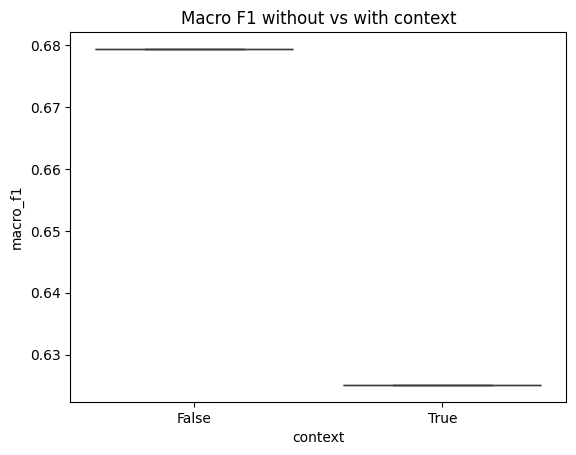

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.boxplot(data=df_context, x="context", y="macro_f1")
plt.title("Macro F1 without vs with context")
plt.show()

In [18]:
import torch, numpy as np, random
from collections import defaultdict
import pandas as pd
from transformers import AutoModelForSequenceClassification , Trainer, TrainingArguments, EarlyStoppingCallback


# Mapping from strategy name to dataset pair
strategies = {
    "no_context": (train_ds_nocontext, val_ds_nocontext),
    # "context": (train_ds_context, val_ds_context),
    # "context_full": (train_ds_context_full, val_ds_context_full),
    "prompt_no_context": (train_ds_prompt_nocontext, val_ds_prompt_nocontext),
    # "prompt_context": (train_ds_prompt_context, val_ds_prompt_context),
    # "prompt_context_full": (train_ds_prompt_context_full, val_ds_prompt_context_full),
}

results = []

for name, (train_ds, val_ds) in strategies.items():
    print(f"\n==== Running: {name}")

    # Load model
    model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)
    args = TrainingArguments(
        output_dir="./outputs_mistake_id",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=1e-5,                     # smaller LR for large models
        per_device_train_batch_size=8,          
        per_device_eval_batch_size=8,
        num_train_epochs=4,                     
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="macro_f1",
        save_total_limit=1,
        fp16=torch.cuda.is_available(),         # mixed precision helps on A100s
        logging_dir="./logs",
        warmup_ratio=0.1,                       # important for stable training
        lr_scheduler_type="linear",             # default, but can try "cosine"
        report_to="none",                       # disable wandb/tensorboard unless needed
        # gradient_accumulation_steps=2,        # effectively increase batch size
        gradient_checkpointing=True,            # save memory
        seed=SEED
    )
    # Trainer
    trainer = CustomTrainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
        data_collator=data_collator,
        gamma=None,
        alpha=None,
        weights=None,
    )

    # Train & evaluate
    trainer.train()
    metrics = trainer.evaluate()

    # Save results
    results.append({
        "strategy": name,
        "loss": metrics.get("eval_loss", -1),
        "macro_f1": metrics.get("eval_macro_f1", -1),
        "lenient_f1": metrics.get("eval_lenient_f1", -1),
        "accuracy": metrics.get("eval_accuracy", -1),
        "lenient_accuracy": metrics.get("eval_lenient_accuracy", -1)
    })

# Final results as DataFrame
df_strategies = pd.DataFrame(results)



==== Running: no_context


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.423513,0.618836,0.675918,0.808219,0.967742
2,No log,0.479121,0.591519,0.625871,0.823712,0.960187
3,0.465100,0.658379,0.626723,0.664783,0.843069,0.962353


Confusion Matrix:
[[ 45   2  26]
 [  0   8  23]
 [  0   7 382]]
Confusion Matrix:
[[ 49   1  23]
 [  3   4  24]
 [  7   3 379]]
Confusion Matrix:
[[ 52   1  20]
 [  4   6  21]
 [  7   3 379]]


Confusion Matrix:
[[ 45   2  26]
 [  0   8  23]
 [  0   7 382]]

==== Running: prompt_no_context


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.430320,0.626443,0.666462,0.812688,0.966474
2,No log,0.467092,0.654040,0.712383,0.825196,0.967517
3,0.473500,0.570612,0.641185,0.680673,0.847538,0.961039
4,0.473500,0.648065,0.662597,0.704262,0.840982,0.966082


Confusion Matrix:
[[ 46   3  24]
 [  0   9  22]
 [  2  14 373]]
Confusion Matrix:
[[ 48   2  23]
 [  0  10  21]
 [  3   4 382]]
Confusion Matrix:
[[ 53   1  19]
 [  4   7  20]
 [  9   2 378]]
Confusion Matrix:
[[ 51   1  21]
 [  2  10  19]
 [  5   8 376]]


Confusion Matrix:
[[ 48   2  23]
 [  0  10  21]
 [  3   4 382]]


In [34]:
df_strategies

,strategy,loss,macro_f1,lenient_f1,accuracy,lenient_accuracy
0,no_context,0.423513,0.675918,0.967742,0.618836,0.808219
1,context,0.474977,0.649496,0.966318,0.601990,0.824005
2,context_full,0.613032,0.641341,0.957647,0.612450,0.826990
3,prompt_no_context,0.436352,0.695122,0.963658,0.660883,0.838601
4,prompt_context,0.704603,0.679949,0.962441,0.649274,0.837410
5,prompt_context_full,0.603136,0.674029,0.964953,0.638239,0.834132


In [15]:
prompt_templates = {
    # "p1_original": "Rate how well the tutor identifies the student's mistake on a scale from 0 (not at all) to 2 (clearly).",
    # "p2_short": "How well does the tutor identify the student's mistake? Student: {student_turn}",
    "p3_evaluator": "You're evaluating a tutor's response. Score how clearly they identify the student's mistake.",
    "p4_ordinal": "To what extent does the tutor identify the mistake? 0 = not at all, 1 = partially, 2 = fully.",
    # "p5_multichoice": "Does the tutor identify the student's mistake fully, partially, or not at all?",
}


In [16]:
def make_prompt_tokenizer(prompt_template):
    def tokenizer_with_prompt(batch):
        text = [f"{prompt_template} Tutor: {x}" for x in batch["response"]]
        return tokenizer(text, padding=True, truncation=True, max_length=256)
    return tokenizer_with_prompt


In [17]:
from datasets import Dataset
prompt_datasets = {}

for name, template in prompt_templates.items():
    tokenizer_fn = make_prompt_tokenizer(template)
    
    train_ds = Dataset.from_pandas(
        train_df[["last_student_turn", "response", "mistake_identification"]].rename(columns={"mistake_identification": "labels"})
    ).map(tokenizer_fn, batched=True)
    
    val_ds = Dataset.from_pandas(
        val_df[["last_student_turn", "response", "mistake_identification"]].rename(columns={"mistake_identification": "labels"})
    ).map(tokenizer_fn, batched=True)
    
    prompt_datasets[name] = (train_ds, val_ds)


Map: 100% 1983/1983 [00:00<00:00, 7170.98 examples/s]
Map: 100% 493/493 [00:00<00:00, 7526.44 examples/s]
Map: 100% 1983/1983 [00:00<00:00, 7053.33 examples/s]
Map: 100% 493/493 [00:00<00:00, 7004.83 examples/s]


In [22]:
results_prompt_variants = []
from transformers import AutoModelForSequenceClassification , Trainer, TrainingArguments, EarlyStoppingCallback
for name, (train_ds, val_ds) in prompt_datasets.items():
    print(f"\nEvaluating prompt: {name}")

    model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)
    args = TrainingArguments(
    output_dir="./outputs_mistake_id",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-5,                     # smaller LR for large models
    per_device_train_batch_size=8,          
    per_device_eval_batch_size=8,
    num_train_epochs=4,                     
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model="macro_f1",
    save_total_limit=1,
    fp16=torch.cuda.is_available(),         # mixed precision helps on A100s
    logging_dir="./logs",
    warmup_ratio=0.1,                       # important for stable training
    lr_scheduler_type="linear",             # default, but can try "cosine"
    report_to="none",                       # disable wandb/tensorboard unless needed
    # gradient_accumulation_steps=2,        # effectively increase batch size
    gradient_checkpointing=True,            # save memory
    seed=SEED
    )
    trainer = CustomTrainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
        data_collator=data_collator,
        gamma=None,
        alpha=None,
        weights=None,
    )

    trainer.train()
    metrics = trainer.evaluate()

    results_prompt_variants.append({
        "prompt_variant": name,
        "loss": metrics.get("eval_loss", -1),
        "macro_f1": metrics.get("eval_macro_f1", -1),
        "lenient_f1": metrics.get("eval_lenient_f1", -1),
        "accuracy": metrics.get("eval_accuracy", -1),
        "lenient_accuracy": metrics.get("eval_lenient_accuracy", -1),
    })

df_prompt_variants = pd.DataFrame(results_prompt_variants)



Evaluating prompt: p3_evaluator


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
W0425 11:10:08.491000 488 torch/_dynamo/convert_frame.py:1233] WON'T CONVERT compiled_embeddings /usr/local/lib/python3.10/dist-packages/transformers/models/modernbert/modeling_modernbert.py line 206 
W0425 11:10:08.491000 488 torch/_dynamo/convert_frame.py:1233] due to: 
W0425 11:10:08.491000 488 torch/_dynamo/convert_frame.py:1233] Traceback (most recent call last):
W0425 11:10:08.491000 488 torch/_dynamo/convert_frame.py:1233]   File "/usr/local/lib/python3.10/dist-packages/torch/_dynamo/convert_frame.py", line 1164, in __call__
W0425 11:10:08.491000 488 torch/_dynamo/convert_frame.py:1233]     result = self._inner_convert(
W0425 11:10:08.491000 488 torch/_dynamo/convert_frame.p

Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.433304,0.596287,0.645564,0.779631,0.962113
2,No log,0.460651,0.645764,0.704135,0.813878,0.967667
3,0.463500,0.595441,0.644613,0.693478,0.851109,0.964706
4,0.463500,0.632944,0.671730,0.711160,0.854680,0.968347


Confusion Matrix:
[[ 41   3  29]
 [  0   8  23]
 [  1  11 377]]
Confusion Matrix:
[[ 46   3  24]
 [  0  10  21]
 [  1   5 383]]
Confusion Matrix:
[[ 53   1  19]
 [  3   7  21]
 [  7   0 382]]
Confusion Matrix:
[[ 53   1  19]
 [  2  10  19]
 [  5   8 376]]


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Confusion Matrix:
[[ 53   1  19]
 [  2  10  19]
 [  5   8 376]]

Evaluating prompt: p4_ordinal


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.478668,0.670967,0.696689,0.828180,0.958872
2,No log,0.454511,0.618930,0.677173,0.819537,0.967593
3,0.481000,0.644514,0.620537,0.654791,0.846347,0.959811


Confusion Matrix:
[[ 50   1  22]
 [  1  12  18]
 [ 11  12 366]]
Confusion Matrix:
[[ 47   2  24]
 [  0   7  24]
 [  2   3 384]]
Confusion Matrix:
[[ 53   0  20]
 [  5   5  21]
 [  9   1 379]]


Confusion Matrix:
[[ 50   1  22]
 [  1  12  18]
 [ 11  12 366]]


In [39]:
df_prompt_variants # pt last student utterance + response

,prompt_variant,loss,macro_f1,lenient_f1,accuracy,lenient_accuracy
0,p1_original,0.606048,0.655605,0.958482,0.630714,0.850815
1,p2_short,0.483254,0.632456,0.963303,0.580780,0.780822
2,p3_evaluator,0.682102,0.681311,0.960187,0.642712,0.823712
3,p4_ordinal,0.782022,0.658052,0.962704,0.624823,0.820434
4,p5_multichoice,0.761852,0.678965,0.967366,0.638239,0.836513


In [47]:
df_prompt_variants # pt response only (second run, current code)

,prompt_variant,loss,macro_f1,lenient_f1,accuracy,lenient_accuracy
0,p1_original,0.633259,0.679872,0.957346,0.639472,0.843966
1,p2_short,0.411817,0.690386,0.964079,0.641480,0.810307
2,p3_evaluator,0.449049,0.696374,0.966318,0.635105,0.824005
3,p4_ordinal,0.430081,0.701408,0.967517,0.644144,0.825196
4,p5_multichoice,0.461603,0.689321,0.971031,0.628919,0.834426


In [48]:
results_prompt_variants = []

for name, (train_ds, val_ds) in prompt_datasets.items():
    print(f"\nEvaluating prompt: {name}")

    model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)

    trainer = CustomTrainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=val_ds,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
        data_collator=data_collator,
        gamma=None,
        alpha=None,
        weights=weights,
        loss_type="weighted",
    )

    trainer.train()
    metrics = trainer.evaluate()

    results_prompt_variants.append({
        "prompt_variant": name,
        "loss": metrics.get("eval_loss", -1),
        "macro_f1": metrics.get("eval_macro_f1", -1),
        "lenient_f1": metrics.get("eval_lenient_f1", -1),
        "accuracy": metrics.get("eval_accuracy", -1),
        "lenient_accuracy": metrics.get("eval_lenient_accuracy", -1),
    })

df_prompt_variants_weighted = pd.DataFrame(results_prompt_variants)


Evaluating prompt: p1_original


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.866215,0.631096,0.495984,0.833252,0.946108
2,No log,0.733969,0.678856,0.672725,0.840688,0.959906
3,0.877000,1.492566,0.624059,0.657778,0.829371,0.960094
4,0.877000,1.740148,0.598844,0.630132,0.826093,0.962617


Confusion Matrix:
[[ 53  11   9]
 [  4  22   5]
 [ 21 190 178]]
              precision    recall  f1-score   support

          No       0.68      0.73      0.70        73
         TSE       0.10      0.71      0.17        31
         Yes       0.93      0.46      0.61       389

    accuracy                           0.51       493
   macro avg       0.57      0.63      0.50       493
weighted avg       0.84      0.51      0.60       493

Confusion Matrix:
[[ 52   3  18]
 [  2  13  16]
 [ 11  26 352]]
              precision    recall  f1-score   support

          No       0.80      0.71      0.75        73
         TSE       0.31      0.42      0.36        31
         Yes       0.91      0.90      0.91       389

    accuracy                           0.85       493
   macro avg       0.67      0.68      0.67       493
weighted avg       0.86      0.85      0.85       493

Confusion Matrix:
[[ 50   2  21]
 [  3   7  21]
 [  8   7 374]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 52   3  18]
 [  2  13  16]
 [ 11  26 352]]
              precision    recall  f1-score   support

          No       0.80      0.71      0.75        73
         TSE       0.31      0.42      0.36        31
         Yes       0.91      0.90      0.91       389

    accuracy                           0.85       493
   macro avg       0.67      0.68      0.67       493
weighted avg       0.86      0.85      0.85       493


Evaluating prompt: p2_short


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.782599,0.650826,0.552517,0.846363,0.935287
2,No log,0.769839,0.687425,0.697117,0.847831,0.967213
3,0.855000,1.480182,0.607214,0.634262,0.848728,0.962264
4,0.855000,1.561888,0.620725,0.646148,0.843069,0.962353


Confusion Matrix:
[[ 57   4  12]
 [  5  16  10]
 [ 32 102 255]]
              precision    recall  f1-score   support

          No       0.61      0.78      0.68        73
         TSE       0.13      0.52      0.21        31
         Yes       0.92      0.66      0.77       389

    accuracy                           0.67       493
   macro avg       0.55      0.65      0.55       493
weighted avg       0.82      0.67      0.72       493

Confusion Matrix:
[[ 52   3  18]
 [  1  13  17]
 [  6  21 362]]
              precision    recall  f1-score   support

          No       0.88      0.71      0.79        73
         TSE       0.35      0.42      0.38        31
         Yes       0.91      0.93      0.92       389

    accuracy                           0.87       493
   macro avg       0.71      0.69      0.70       493
weighted avg       0.87      0.87      0.87       493

Confusion Matrix:
[[ 53   0  20]
 [  3   4  24]
 [  9   4 376]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 52   3  18]
 [  1  13  17]
 [  6  21 362]]
              precision    recall  f1-score   support

          No       0.88      0.71      0.79        73
         TSE       0.35      0.42      0.38        31
         Yes       0.91      0.93      0.92       389

    accuracy                           0.87       493
   macro avg       0.71      0.69      0.70       493
weighted avg       0.87      0.87      0.87       493


Evaluating prompt: p3_evaluator


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.787359,0.645392,0.535088,0.836530,0.943442
2,No log,0.728055,0.680851,0.669314,0.848728,0.962264
3,0.869900,1.500490,0.625291,0.654246,0.846347,0.959811
4,0.869900,1.427365,0.652983,0.684045,0.840688,0.959906


Confusion Matrix:
[[ 54   5  14]
 [  4  19   8]
 [ 24 138 227]]
              precision    recall  f1-score   support

          No       0.66      0.74      0.70        73
         TSE       0.12      0.61      0.20        31
         Yes       0.91      0.58      0.71       389

    accuracy                           0.61       493
   macro avg       0.56      0.65      0.54       493
weighted avg       0.82      0.61      0.68       493

Confusion Matrix:
[[ 53   3  17]
 [  3  13  15]
 [  9  31 349]]
              precision    recall  f1-score   support

          No       0.82      0.73      0.77        73
         TSE       0.28      0.42      0.33        31
         Yes       0.92      0.90      0.91       389

    accuracy                           0.84       493
   macro avg       0.67      0.68      0.67       493
weighted avg       0.86      0.84      0.85       493

Confusion Matrix:
[[ 53   0  20]
 [  3   6  22]
 [ 11   6 372]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 52   1  20]
 [  4   9  18]
 [  9   8 372]]
              precision    recall  f1-score   support

          No       0.80      0.71      0.75        73
         TSE       0.50      0.29      0.37        31
         Yes       0.91      0.96      0.93       389

    accuracy                           0.88       493
   macro avg       0.74      0.65      0.68       493
weighted avg       0.87      0.88      0.87       493


Evaluating prompt: p4_ordinal


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.831902,0.620367,0.521701,0.806442,0.954279
2,No log,0.714120,0.696077,0.676008,0.839498,0.958678
3,0.869300,1.428256,0.649743,0.675402,0.863324,0.959524
4,0.869300,1.513381,0.680769,0.713523,0.854680,0.968347


Confusion Matrix:
[[ 47  15  11]
 [  2  21   8]
 [ 11 168 210]]
              precision    recall  f1-score   support

          No       0.78      0.64      0.71        73
         TSE       0.10      0.68      0.18        31
         Yes       0.92      0.54      0.68       389

    accuracy                           0.56       493
   macro avg       0.60      0.62      0.52       493
weighted avg       0.85      0.56      0.65       493

Confusion Matrix:
[[ 52   4  17]
 [  2  15  14]
 [ 12  30 347]]
              precision    recall  f1-score   support

          No       0.79      0.71      0.75        73
         TSE       0.31      0.48      0.38        31
         Yes       0.92      0.89      0.90       389

    accuracy                           0.84       493
   macro avg       0.67      0.70      0.68       493
weighted avg       0.86      0.84      0.85       493

Confusion Matrix:
[[ 56   0  17]
 [  5   7  19]
 [ 12   5 372]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 53   2  18]
 [  2  11  18]
 [  5  10 374]]
              precision    recall  f1-score   support

          No       0.88      0.73      0.80        73
         TSE       0.48      0.35      0.41        31
         Yes       0.91      0.96      0.94       389

    accuracy                           0.89       493
   macro avg       0.76      0.68      0.71       493
weighted avg       0.88      0.89      0.88       493


Evaluating prompt: p5_multichoice


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.848364,0.631672,0.507318,0.814775,0.962791
2,No log,0.802787,0.666014,0.666438,0.827283,0.963827
3,0.849800,1.562314,0.601979,0.620561,0.827886,0.952607
4,0.849800,1.772162,0.616065,0.643306,0.822521,0.958968


Confusion Matrix:
[[ 47  15  11]
 [  1  25   5]
 [  5 211 173]]
              precision    recall  f1-score   support

          No       0.89      0.64      0.75        73
         TSE       0.10      0.81      0.18        31
         Yes       0.92      0.44      0.60       389

    accuracy                           0.50       493
   macro avg       0.63      0.63      0.51       493
weighted avg       0.86      0.50      0.59       493

Confusion Matrix:
[[ 49   4  20]
 [  1  13  17]
 [  6  30 353]]
              precision    recall  f1-score   support

          No       0.88      0.67      0.76        73
         TSE       0.28      0.42      0.33        31
         Yes       0.91      0.91      0.91       389

    accuracy                           0.84       493
   macro avg       0.69      0.67      0.67       493
weighted avg       0.86      0.84      0.85       493

Confusion Matrix:
[[ 51   2  20]
 [  4   5  22]
 [ 14   7 368]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 49   4  20]
 [  1  13  17]
 [  6  30 353]]
              precision    recall  f1-score   support

          No       0.88      0.67      0.76        73
         TSE       0.28      0.42      0.33        31
         Yes       0.91      0.91      0.91       389

    accuracy                           0.84       493
   macro avg       0.69      0.67      0.67       493
weighted avg       0.86      0.84      0.85       493



In [49]:
df_prompt_variants_weighted

,prompt_variant,loss,macro_f1,lenient_f1,accuracy,lenient_accuracy
0,p1_original,0.733969,0.672725,0.959906,0.678856,0.840688
1,p2_short,0.769839,0.697117,0.967213,0.687425,0.847831
2,p3_evaluator,1.427365,0.684045,0.959906,0.652983,0.840688
3,p4_ordinal,1.513381,0.713523,0.968347,0.680769,0.854680
4,p5_multichoice,0.802787,0.666438,0.963827,0.666014,0.827283


In [33]:
weights

tensor([ 6.6768, 13.8671,  1.2852])

In [34]:
import torch, numpy as np, random
from collections import defaultdict
import pandas as pd

results = []
loss_types = ["weighted", "focal"]

for loss_type in loss_types:
        print(f"\n==== Running: loss_type={loss_type}")
       
        # Define trainer
        model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)

        trainer = CustomTrainer(
            model=model,
            args=args,
            train_dataset=prompt_datasets["p3_evaluator"][0],
            eval_dataset=prompt_datasets["p3_evaluator"][1],
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
            loss_type=loss_type,
            data_collator=data_collator,
            alpha=cb_alpha,
            gamma=2.0,
            weights=weights,
        )

        trainer.train()
        metrics = trainer.evaluate()

        # Save results
        results.append({
        "loss_type": loss_type,
        "loss": metrics.get("eval_loss", -1),
        "macro_f1": metrics.get("eval_macro_f1", -1),
        "lenient_f1": metrics.get("eval_lenient_f1", -1),
        "accuracy": metrics.get("eval_accuracy", -1),
        "lenient_accuracy": metrics.get("eval_lenient_accuracy", -1)
      })


# Create result DataFrame
df_loss = pd.DataFrame(results)


==== Running: loss_type=weighted


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.843824,0.637682,0.524510,0.797798,0.963048
2,No log,0.769813,0.676192,0.668598,0.836513,0.967366
3,0.867500,1.393046,0.624047,0.631045,0.840395,0.953627
4,0.867500,1.900237,0.620632,0.646833,0.829371,0.960094


Confusion Matrix:
[[ 44  17  12]
 [  0  25   6]
 [  3 190 196]]
Confusion Matrix:
[[ 50   4  19]
 [  0  14  17]
 [  5  37 347]]
Confusion Matrix:
[[ 53   2  18]
 [  4   7  20]
 [ 15  16 358]]
Confusion Matrix:
[[ 50   2  21]
 [  4   7  20]
 [  7  12 370]]


Confusion Matrix:
[[ 50   4  19]
 [  0  14  17]
 [  5  37 347]]

==== Running: loss_type=focal


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.162691,0.673270,0.543606,0.860372,0.918444
2,No log,0.193075,0.647949,0.660538,0.779631,0.962113
3,0.184100,0.290311,0.654791,0.694798,0.855577,0.963400
4,0.184100,0.369687,0.690853,0.703584,0.847831,0.967213


Confusion Matrix:
[[ 62   3   8]
 [  6  17   8]
 [ 48  99 242]]
Confusion Matrix:
[[ 41   8  24]
 [  0  14  17]
 [  1  26 362]]
Confusion Matrix:
[[ 54   0  19]
 [  3   8  20]
 [  9   4 376]]
Confusion Matrix:
[[ 52   4  17]
 [  2  13  16]
 [  5  18 366]]


Confusion Matrix:
[[ 52   4  17]
 [  2  13  16]
 [  5  18 366]]


In [35]:
df_loss

,loss_type,loss,macro_f1,lenient_f1,accuracy,lenient_accuracy
0,weighted,0.769813,0.668598,0.967366,0.676192,0.836513
1,focal,0.369687,0.703584,0.967213,0.690853,0.847831


In [28]:
import torch, numpy as np, random
from collections import defaultdict
import pandas as pd

results = []
loss_types = ["weighted", "focal"]

for loss_type in loss_types:
        print(f"\n==== Running: loss_type={loss_type}")
       
        # Define trainer
        model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)

        trainer = CustomTrainer(
            model=model,
            args=args,
            train_dataset=train_ds_nocontext,
            eval_dataset=val_ds_nocontext,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
            loss_type=loss_type,
            data_collator=data_collator,
        )

        trainer.train()
        metrics = trainer.evaluate()

        # Save results
        results.append({
        "loss_type": loss_type,
        "loss": metrics.get("eval_loss", -1),
        "macro_f1": metrics.get("eval_macro_f1", -1),
        "lenient_f1": metrics.get("eval_lenient_f1", -1),
        "accuracy": metrics.get("eval_accuracy", -1),
        "lenient_accuracy": metrics.get("eval_lenient_accuracy", -1)
      })


# Create result DataFrame
df_loss = pd.DataFrame(results)


==== Running: loss_type=weighted


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.824820,0.638620,0.511255,0.838911,0.945978
2,No log,0.740811,0.687425,0.699934,0.840688,0.959906
3,0.855500,1.351347,0.631384,0.660098,0.826990,0.957647
4,0.855500,1.580085,0.643476,0.688420,0.814775,0.962791


Confusion Matrix:
[[ 54  10   9]
 [  5  21   5]
 [ 21 174 194]]
              precision    recall  f1-score   support

          No       0.68      0.74      0.71        73
         TSE       0.10      0.68      0.18        31
         Yes       0.93      0.50      0.65       389

    accuracy                           0.55       493
   macro avg       0.57      0.64      0.51       493
weighted avg       0.84      0.55      0.63       493

Confusion Matrix:
[[ 52   2  19]
 [  1  13  17]
 [ 12  15 362]]
              precision    recall  f1-score   support

          No       0.80      0.71      0.75        73
         TSE       0.43      0.42      0.43        31
         Yes       0.91      0.93      0.92       389

    accuracy                           0.87       493
   macro avg       0.71      0.69      0.70       493
weighted avg       0.86      0.87      0.86       493

Confusion Matrix:
[[ 50   2  21]
 [  3   8  20]
 [ 10   9 370]]
              precision    recall  f1-score   

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Confusion Matrix:
[[ 52   2  19]
 [  1  13  17]
 [ 12  15 362]]
              precision    recall  f1-score   support

          No       0.80      0.71      0.75        73
         TSE       0.43      0.42      0.43        31
         Yes       0.91      0.93      0.92       389

    accuracy                           0.87       493
   macro avg       0.71      0.69      0.70       493
weighted avg       0.86      0.87      0.86       493


==== Running: loss_type=focal


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.197195,0.612182,0.647191,0.746575,0.957811
2,No log,0.185868,0.637958,0.693380,0.830855,0.967442
3,0.202500,0.319861,0.652220,0.686482,0.848434,0.956005
4,0.202500,0.339357,0.639096,0.684906,0.832942,0.963743


Confusion Matrix:
[[ 36   6  31]
 [  0  12  19]
 [  0  17 372]]
              precision    recall  f1-score   support

          No       1.00      0.49      0.66        73
         TSE       0.34      0.39      0.36        31
         Yes       0.88      0.96      0.92       389

    accuracy                           0.85       493
   macro avg       0.74      0.61      0.65       493
weighted avg       0.87      0.85      0.84       493

Confusion Matrix:
[[ 49   2  22]
 [  1   8  22]
 [  3   3 383]]
              precision    recall  f1-score   support

          No       0.92      0.67      0.78        73
         TSE       0.62      0.26      0.36        31
         Yes       0.90      0.98      0.94       389

    accuracy                           0.89       493
   macro avg       0.81      0.64      0.69       493
weighted avg       0.88      0.89      0.88       493

Confusion Matrix:
[[ 54   0  19]
 [  5   8  18]
 [ 13   3 373]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 49   2  22]
 [  1   8  22]
 [  3   3 383]]
              precision    recall  f1-score   support

          No       0.92      0.67      0.78        73
         TSE       0.62      0.26      0.36        31
         Yes       0.90      0.98      0.94       389

    accuracy                           0.89       493
   macro avg       0.81      0.64      0.69       493
weighted avg       0.88      0.89      0.88       493



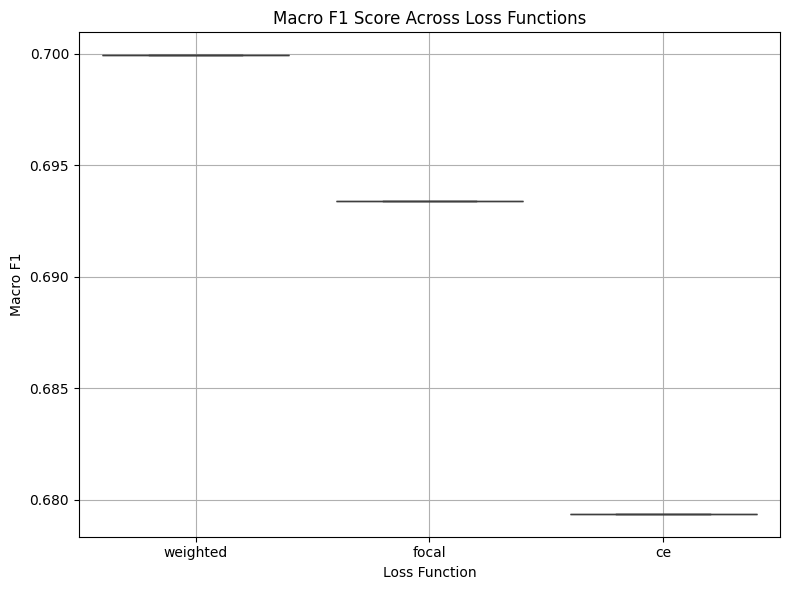

In [30]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=df_loss, x="loss_type", y="macro_f1")
plt.title("Macro F1 Score Across Loss Functions")
plt.ylabel("Macro F1")
plt.xlabel("Loss Function")
plt.grid(True)
plt.tight_layout()
plt.show()

**Focal Loss hyperparam tuning**

In [36]:
import torch, numpy as np, random
from collections import defaultdict
import pandas as pd

alphas = [
    # torch.tensor([1.0, 1.0, 1.0]),       # unweighted focal
    # weights,                             # inverse freq
    cb_alpha
]
gammas = [1.0, 1.3, 1.5, 2.0, 2.2, 2.5, 3.0]
focal_results = []

for alpha in alphas:
    
    for gamma in gammas:
            print(f"\n==== Running: alpha={alpha.tolist()}, gamma={gamma}")

            model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)

            trainer = CustomTrainer(
                model=model,
                args=args,
                train_dataset=prompt_datasets["p3_evaluator"][0],
                eval_dataset=prompt_datasets["p3_evaluator"][1],
                compute_metrics=compute_metrics,
                callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
                loss_type="focal",
                weights=None,         # not used in focal mode
                alpha=alpha,
                gamma=gamma,
                data_collator=data_collator
            )

            trainer.train()
            metrics = trainer.evaluate()

            focal_results.append({
                "alpha": alpha.tolist(),
                "gamma": gamma,
                "loss": metrics.get("eval_loss", -1),
                "macro_f1": metrics.get("eval_macro_f1", -1),
                "lenient_f1": metrics.get("eval_lenient_f1", -1),
                "accuracy": metrics.get("eval_accuracy", -1),
                "lenient_accuracy": metrics.get("eval_lenient_accuracy", -1)
            })

# Save as DataFrame
df_focal_p4 = pd.DataFrame(focal_results)


==== Running: alpha=[0.9215896129608154, 1.7771633863449097, 0.30124688148498535], gamma=1.0


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.235426,0.675571,0.567663,0.846070,0.928571
2,No log,0.241437,0.677436,0.684092,0.835323,0.966161
3,0.271900,0.465452,0.650024,0.670034,0.864220,0.954436
4,0.271900,0.520468,0.668209,0.691170,0.836220,0.961222


Confusion Matrix:
[[ 58   4  11]
 [  5  17   9]
 [ 38  85 266]]
Confusion Matrix:
[[ 50   6  17]
 [  1  13  17]
 [  5  23 361]]
Confusion Matrix:
[[ 57   0  16]
 [  4   7  20]
 [ 18   4 367]]
Confusion Matrix:
[[ 51   4  18]
 [  3  11  17]
 [  8  11 370]]


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Confusion Matrix:
[[ 51   4  18]
 [  3  11  17]
 [  8  11 370]]

==== Running: alpha=[0.9215896129608154, 1.7771633863449097, 0.30124688148498535], gamma=1.3


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.203987,0.673387,0.573940,0.843689,0.925926
2,No log,0.219962,0.658314,0.668623,0.807926,0.961672
3,0.243900,0.343234,0.665825,0.689719,0.860046,0.962085
4,0.243900,0.461091,0.647748,0.660836,0.832942,0.963743


Confusion Matrix:
[[ 58   4  11]
 [  5  16  10]
 [ 40  73 276]]
Confusion Matrix:
[[ 46   6  21]
 [  0  13  18]
 [  6  23 360]]
Confusion Matrix:
[[ 55   2  16]
 [  4   9  18]
 [ 10   8 371]]
Confusion Matrix:
[[ 50   7  16]
 [  3  10  18]
 [  5  20 364]]


Confusion Matrix:
[[ 55   2  16]
 [  4   9  18]
 [ 10   8 371]]

==== Running: alpha=[0.9215896129608154, 1.7771633863449097, 0.30124688148498535], gamma=1.5


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.184134,0.682719,0.600728,0.856181,0.952038
2,No log,0.214319,0.666120,0.693181,0.826386,0.968714
3,0.226100,0.414932,0.624634,0.675180,0.827283,0.963827
4,0.226100,0.434704,0.659170,0.690586,0.842172,0.967290


Confusion Matrix:
[[ 56   5  12]
 [  4  17  10]
 [ 19  85 285]]
Confusion Matrix:
[[ 48   5  20]
 [  1  12  18]
 [  1  17 371]]
Confusion Matrix:
[[ 49   0  24]
 [  2   7  22]
 [  5   4 380]]
Confusion Matrix:
[[ 51   3  19]
 [  1  10  20]
 [  5  12 372]]


Confusion Matrix:
[[ 48   5  20]
 [  1  12  18]
 [  1  17 371]]

==== Running: alpha=[0.9215896129608154, 1.7771633863449097, 0.30124688148498535], gamma=2.0


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.162864,0.682696,0.557744,0.862753,0.921151
2,No log,0.175298,0.681815,0.681597,0.815965,0.963995
3,0.186000,0.301683,0.653077,0.687446,0.850815,0.958482
4,0.186000,0.379886,0.686286,0.703429,0.840982,0.966082


Confusion Matrix:
[[ 62   3   8]
 [  6  17   8]
 [ 46  90 253]]
Confusion Matrix:
[[ 47   5  21]
 [  1  15  15]
 [  4  28 357]]
Confusion Matrix:
[[ 54   0  19]
 [  5   8  18]
 [ 11   4 374]]
Confusion Matrix:
[[ 51   3  19]
 [  1  13  17]
 [  6  17 366]]


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Confusion Matrix:
[[ 51   3  19]
 [  1  13  17]
 [  6  17 366]]

==== Running: alpha=[0.9215896129608154, 1.7771633863449097, 0.30124688148498535], gamma=2.2


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.152214,0.656718,0.543125,0.858888,0.910013
2,No log,0.166358,0.657939,0.672340,0.794521,0.965517
3,0.173700,0.284422,0.641185,0.682796,0.851109,0.964706
4,0.173700,0.380034,0.610267,0.644866,0.801076,0.960557


Confusion Matrix:
[[ 63   3   7]
 [  8  14   9]
 [ 53  81 255]]
Confusion Matrix:
[[ 43   7  23]
 [  0  14  17]
 [  0  26 363]]
Confusion Matrix:
[[ 53   0  20]
 [  3   7  21]
 [  7   4 378]]
Confusion Matrix:
[[ 45   4  24]
 [  2   8  21]
 [  4  13 372]]


Confusion Matrix:
[[ 53   0  20]
 [  3   7  21]
 [  7   4 378]]

==== Running: alpha=[0.9215896129608154, 1.7771633863449097, 0.30124688148498535], gamma=2.5


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.130406,0.665382,0.548658,0.844292,0.913425
2,No log,0.150689,0.678387,0.672589,0.815965,0.963995
3,0.154700,0.257216,0.631103,0.665087,0.823712,0.960187
4,0.154700,0.353158,0.634143,0.650859,0.822521,0.958968


Confusion Matrix:
[[ 60   4   9]
 [  6  16   9]
 [ 50  83 256]]
Confusion Matrix:
[[ 47   6  20]
 [  1  15  15]
 [  4  32 353]]
Confusion Matrix:
[[ 49   3  21]
 [  4   8  19]
 [  6   8 375]]
Confusion Matrix:
[[ 49   6  18]
 [  4   9  18]
 [  7  16 366]]


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Confusion Matrix:
[[ 47   6  20]
 [  1  15  15]
 [  4  32 353]]

==== Running: alpha=[0.9215896129608154, 1.7771633863449097, 0.30124688148498535], gamma=3.0


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.106748,0.668516,0.543647,0.853229,0.910240
2,No log,0.122453,0.661836,0.659566,0.789759,0.960739
3,0.128600,0.234699,0.618730,0.651789,0.832648,0.957547
4,0.128600,0.293415,0.647467,0.669909,0.824902,0.961404


Confusion Matrix:
[[ 62   4   7]
 [  6  16   9]
 [ 54  86 249]]
Confusion Matrix:
[[ 43   8  22]
 [  1  15  15]
 [  3  31 355]]
Confusion Matrix:
[[ 51   1  21]
 [  4   6  21]
 [ 10   4 375]]
Confusion Matrix:
[[ 49   4  20]
 [  4  10  17]
 [  5  15 369]]


Confusion Matrix:
[[ 49   4  20]
 [  4  10  17]
 [  5  15 369]]


In [37]:
df_focal_p3 

,alpha,gamma,loss,macro_f1,lenient_f1,accuracy,lenient_accuracy
0,"[0.9215896129608154, 1.7771633863449097, 0.301...",1.0,0.520468,0.691170,0.961222,0.668209,0.836220
1,"[0.9215896129608154, 1.7771633863449097, 0.301...",1.3,0.343234,0.689719,0.962085,0.665825,0.860046
2,"[0.9215896129608154, 1.7771633863449097, 0.301...",1.5,0.214319,0.693181,0.968714,0.666120,0.826386
3,"[0.9215896129608154, 1.7771633863449097, 0.301...",2.0,0.379886,0.703429,0.966082,0.686286,0.840982
4,"[0.9215896129608154, 1.7771633863449097, 0.301...",2.2,0.284422,0.682796,0.964706,0.641185,0.851109
5,"[0.9215896129608154, 1.7771633863449097, 0.301...",2.5,0.150689,0.672589,0.963995,0.678387,0.815965
6,"[0.9215896129608154, 1.7771633863449097, 0.301...",3.0,0.293415,0.669909,0.961404,0.647467,0.824902


In [40]:
import numpy as np
from sklearn.metrics import f1_score
from collections import defaultdict
from transformers import set_seed

SEEDS = [42, 123, 456]
LOSS_TYPES = ["cross_entropy", "focal"] 
CLASS_NAMES = ["No", "TSE", "Yes"]  
MINORITY_CLASSES = [0, 1]  

results = defaultdict(lambda: {
    "macro_f1": [],
    "per_class_f1": {c: [] for c in range(len(CLASS_NAMES))}
})
train_ds = prompt_datasets["p3_evaluator"][0]
val_ds = prompt_datasets["p3_evaluator"][1]
for seed in SEEDS:
    set_seed(seed)  
    for loss_type in LOSS_TYPES:
        print(f"\nTesting seed={seed}, loss={loss_type}")
        
        model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)
        
        trainer = CustomTrainer(
                model=model,
                args=args,
                train_dataset=train_ds,
                eval_dataset=val_ds,
                compute_metrics=compute_metrics,
                callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
                loss_type=loss_type,
                weights=None,
                alpha=cb_alpha,
                gamma=2.0,
                data_collator=data_collator
            )
        
        trainer.train()
        val_preds = trainer.predict(val_ds).predictions.argmax(axis=1)
        val_labels = val_ds["labels"]  
        
        macro_f1 = f1_score(val_labels, val_preds, average="macro")
        results[loss_type]["macro_f1"].append(macro_f1)
        
        for class_idx in range(len(CLASS_NAMES)):
            class_f1 = f1_score(val_labels, val_preds, labels=[class_idx], average="macro")
            results[loss_type]["per_class_f1"][class_idx].append(class_f1)

print("\n=== Results Summary ===")
for loss in LOSS_TYPES:
    macro_f1_mean = np.mean(results[loss]["macro_f1"])
    macro_f1_std = np.std(results[loss]["macro_f1"])
    
    print(f"\n{loss.upper()}:")
    print(f"  Macro F1: {macro_f1_mean:.4f} ± {macro_f1_std:.4f}")
    
    for class_idx in MINORITY_CLASSES:
        class_mean = np.mean(results[loss]["per_class_f1"][class_idx])
        class_std = np.std(results[loss]["per_class_f1"][class_idx])
        print(f"  {CLASS_NAMES[class_idx]} F1: {class_mean:.4f} ± {class_std:.4f}")

ce_macro_std = np.std(results["cross_entropy"]["macro_f1"])
fl_macro_std = np.std(results["focal"]["macro_f1"])

fl_minority_improved = all(
    np.mean(results["focal"]["per_class_f1"][c]) > np.mean(results["cross_entropy"]["per_class_f1"][c])
    for c in MINORITY_CLASSES
)

if fl_macro_std <= ce_macro_std and fl_minority_improved:
    print("\nCONCLUSION: Submit Focal Loss (better minority F1 without added variance)")
else:
    print("\nCONCLUSION: Submit Cross-Entropy (more stable or no minority improvement)")


Testing seed=42, loss=cross_entropy


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.441419,0.651176,0.679008,0.831751,0.962529
2,No log,0.452956,0.623496,0.679168,0.825196,0.967517
3,0.498200,0.609820,0.600170,0.614466,0.852006,0.959716
4,0.498200,0.720045,0.634905,0.666355,0.843069,0.962353


Confusion Matrix:
[[ 50   1  22]
 [  2  10  19]
 [  7  14 368]]
Confusion Matrix:
[[ 48   3  22]
 [  0   7  24]
 [  3   2 384]]
Confusion Matrix:
[[ 54   2  17]
 [  5   3  23]
 [ 10   4 375]]
Confusion Matrix:
[[ 52   3  18]
 [  4   7  20]
 [  7   6 376]]


Confusion Matrix:
[[ 48   3  22]
 [  0   7  24]
 [  3   2 384]]

Testing seed=42, loss=focal


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.170661,0.662412,0.514234,0.843412,0.891753
2,No log,0.174587,0.685336,0.691018,0.826093,0.962617
3,0.185500,0.314490,0.624246,0.656344,0.855577,0.963400
4,0.185500,0.395531,0.645471,0.671888,0.820434,0.962704


Confusion Matrix:
[[ 63   3   7]
 [  7  17   7]
 [ 67  98 224]]
Confusion Matrix:
[[ 49   6  18]
 [  2  14  15]
 [  6  20 363]]
Confusion Matrix:
[[ 54   0  19]
 [  4   5  22]
 [  8   3 378]]
Confusion Matrix:
[[ 48   6  19]
 [  3  10  18]
 [  4  13 372]]


Confusion Matrix:
[[ 49   6  18]
 [  2  14  15]
 [  6  20 363]]


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Testing seed=123, loss=cross_entropy


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.428818,0.631678,0.684837,0.821624,0.963912
2,No log,0.442320,0.630633,0.695737,0.834426,0.971031
3,0.479300,0.556723,0.616064,0.649271,0.857958,0.965842
4,0.479300,0.618489,0.647747,0.678870,0.864808,0.966981


Confusion Matrix:
[[ 48   1  24]
 [  2   8  21]
 [  4   4 381]]
Confusion Matrix:
[[ 49   1  23]
 [  0   7  24]
 [  1   1 387]]
Confusion Matrix:
[[ 54   0  19]
 [  3   4  24]
 [  7   1 381]]
Confusion Matrix:
[[ 55   1  17]
 [  3   7  21]
 [  7   7 375]]


Confusion Matrix:
[[ 49   1  23]
 [  0   7  24]
 [  1   1 387]]

Testing seed=123, loss=focal


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.162691,0.673270,0.543606,0.860372,0.918444
2,No log,0.193075,0.647949,0.660538,0.779631,0.962113
3,0.184100,0.290311,0.654791,0.694798,0.855577,0.963400
4,0.184100,0.369480,0.690853,0.703584,0.847831,0.967213


Confusion Matrix:
[[ 62   3   8]
 [  6  17   8]
 [ 48  99 242]]
Confusion Matrix:
[[ 41   8  24]
 [  0  14  17]
 [  1  26 362]]
Confusion Matrix:
[[ 54   0  19]
 [  3   8  20]
 [  9   4 376]]
Confusion Matrix:
[[ 52   4  17]
 [  2  13  16]
 [  5  18 366]]


Confusion Matrix:
[[ 52   4  17]
 [  2  13  16]
 [  5  18 366]]

Testing seed=456, loss=cross_entropy


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.428736,0.621595,0.670998,0.800179,0.965438
2,No log,0.475312,0.600277,0.644861,0.819243,0.961494
3,0.477000,0.664354,0.632522,0.661007,0.866895,0.963227


Confusion Matrix:
[[ 44   3  26]
 [  0   9  22]
 [  1  10 378]]
Confusion Matrix:
[[ 48   2  23]
 [  2   5  24]
 [  6   1 382]]
Confusion Matrix:
[[ 56   1  16]
 [  3   5  23]
 [ 11   1 377]]


Confusion Matrix:
[[ 44   3  26]
 [  0   9  22]
 [  1  10 378]]

Testing seed=456, loss=focal


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.150198,0.639839,0.614404,0.795417,0.960648
2,No log,0.183764,0.662880,0.671566,0.815965,0.963995
3,0.182100,0.271149,0.662116,0.691647,0.856768,0.964623
4,0.182100,0.361143,0.662879,0.691615,0.847831,0.967213


Confusion Matrix:
[[ 44  11  18]
 [  2  15  14]
 [  3  62 324]]
Confusion Matrix:
[[ 47   6  20]
 [  1  13  17]
 [  4  25 360]]
Confusion Matrix:
[[ 54   1  18]
 [  3   9  19]
 [  8   9 372]]
Confusion Matrix:
[[ 52   2  19]
 [  2  10  19]
 [  5  13 371]]


Confusion Matrix:
[[ 54   1  18]
 [  3   9  19]
 [  8   9 372]]

=== Results Summary ===

CROSS_ENTROPY:
  Macro F1: 0.6820 ± 0.0103
  No F1: 0.7722 ± 0.0209
  TSE F1: 0.3384 ± 0.0100

FOCAL:
  Macro F1: 0.6954 ± 0.0058
  No F1: 0.7748 ± 0.0150
  TSE F1: 0.3828 ± 0.0161

CONCLUSION: Submit Focal Loss (better minority F1 without added variance)


In [64]:
df_focal_p4 # pt plain no_context

,alpha,gamma,loss,macro_f1,lenient_f1,accuracy,lenient_accuracy
0,"[1.0, 1.0, 1.0]",1.0,0.433509,0.667664,0.966002,0.634905,0.846641
1,"[1.0, 1.0, 1.0]",1.3,0.255659,0.699542,0.964789,0.672775,0.845450
2,"[1.0, 1.0, 1.0]",1.5,0.225321,0.687985,0.963912,0.662692,0.821624
3,"[1.0, 1.0, 1.0]",2.0,0.193262,0.700713,0.965278,0.643194,0.811497
4,"[1.0, 1.0, 1.0]",2.2,0.168790,0.695740,0.964953,0.680863,0.834132
5,"[1.0, 1.0, 1.0]",2.5,0.303181,0.705892,0.968568,0.660602,0.837704
6,"[1.0, 1.0, 1.0]",3.0,0.195877,0.673754,0.962441,0.632053,0.837410
7,"[6.676767826080322, 13.867133140563965, 1.2851...",1.0,4.538206,0.684286,0.961313,0.656317,0.830561
8,"[6.676767826080322, 13.867133140563965, 1.2851...",1.3,4.535727,0.665285,0.961131,0.649556,0.841879
9,"[6.676767826080322, 13.867133140563965, 1.2851...",1.5,4.046409,0.684312,0.964789,0.662022,0.845450


In [36]:
import torch, numpy as np, random
from collections import defaultdict
import pandas as pd

alphas = [
    torch.tensor([1.0, 1.0, 1.0]),       # unweighted focal
    weights,                             # inverse freq
    cb_alpha
]
gammas = [1.0, 2.0, 3.0]
focal_results = []

for alpha in alphas:
    for gamma in gammas:
            print(f"\n==== Running: alpha={alpha.tolist()}, gamma={gamma}")

            model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)

            trainer = CustomTrainer(
                model=model,
                args=args,
                train_dataset=train_ds_nocontext,
                eval_dataset=val_ds_nocontext,
                compute_metrics=compute_metrics,
                callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
                loss_type="focal",
                weights=None,         # not used in focal mode
                alpha=alpha,
                gamma=gamma,
                data_collator=data_collator
            )

            trainer.train()
            metrics = trainer.evaluate()

            focal_results.append({
                "alpha": alpha.tolist(),
                "gamma": gamma,
                "loss": metrics.get("eval_loss", -1),
                "macro_f1": metrics.get("eval_macro_f1", -1),
                "lenient_f1": metrics.get("eval_lenient_f1", -1),
                "accuracy": metrics.get("eval_accuracy", -1),
                "lenient_accuracy": metrics.get("eval_lenient_accuracy", -1)
            })

# Save as DataFrame
df_focal = pd.DataFrame(focal_results)


==== Running: alpha=[1.0, 1.0, 1.0], gamma=1.0


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.263639,0.632829,0.692041,0.779631,0.962113
2,No log,0.274601,0.639953,0.691213,0.835323,0.966161
3,0.290900,0.464813,0.612168,0.649364,0.824902,0.961404


Confusion Matrix:
[[ 41   3  29]
 [  0  11  20]
 [  1   6 382]]
              precision    recall  f1-score   support

          No       0.98      0.56      0.71        73
         TSE       0.55      0.35      0.43        31
         Yes       0.89      0.98      0.93       389

    accuracy                           0.88       493
   macro avg       0.80      0.63      0.69       493
weighted avg       0.88      0.88      0.87       493

Confusion Matrix:
[[ 50   1  22]
 [  1   8  22]
 [  5   4 380]]
              precision    recall  f1-score   support

          No       0.89      0.68      0.78        73
         TSE       0.62      0.26      0.36        31
         Yes       0.90      0.98      0.93       389

    accuracy                           0.89       493
   macro avg       0.80      0.64      0.69       493
weighted avg       0.88      0.89      0.88       493

Confusion Matrix:
[[ 49   2  22]
 [  4   6  21]
 [  5   6 378]]
              precision    recall  f1-score   

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Confusion Matrix:
[[ 41   3  29]
 [  0  11  20]
 [  1   6 382]]
              precision    recall  f1-score   support

          No       0.98      0.56      0.71        73
         TSE       0.55      0.35      0.43        31
         Yes       0.89      0.98      0.93       389

    accuracy                           0.88       493
   macro avg       0.80      0.63      0.69       493
weighted avg       0.88      0.88      0.87       493


==== Running: alpha=[1.0, 1.0, 1.0], gamma=2.0


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.193195,0.623885,0.664764,0.760274,0.960000
2,No log,0.200216,0.613600,0.670311,0.825196,0.967517
3,0.198900,0.309029,0.614350,0.643084,0.857958,0.965842
4,0.198900,0.337185,0.668020,0.710180,0.849022,0.968421


Confusion Matrix:
[[ 38   5  30]
 [  0  12  19]
 [  0  14 375]]
              precision    recall  f1-score   support

          No       1.00      0.52      0.68        73
         TSE       0.39      0.39      0.39        31
         Yes       0.88      0.96      0.92       389

    accuracy                           0.86       493
   macro avg       0.76      0.62      0.66       493
weighted avg       0.87      0.86      0.85       493

Confusion Matrix:
[[ 48   1  24]
 [  1   6  24]
 [  2   2 385]]
              precision    recall  f1-score   support

          No       0.94      0.66      0.77        73
         TSE       0.67      0.19      0.30        31
         Yes       0.89      0.99      0.94       389

    accuracy                           0.89       493
   macro avg       0.83      0.61      0.67       493
weighted avg       0.88      0.89      0.87       493

Confusion Matrix:
[[ 54   0  19]
 [  4   4  23]
 [  6   4 379]]
              precision    recall  f1-score   

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Confusion Matrix:
[[ 52   1  20]
 [  2  10  19]
 [  4   8 377]]
              precision    recall  f1-score   support

          No       0.90      0.71      0.79        73
         TSE       0.53      0.32      0.40        31
         Yes       0.91      0.97      0.94       389

    accuracy                           0.89       493
   macro avg       0.78      0.67      0.71       493
weighted avg       0.88      0.89      0.88       493


==== Running: alpha=[1.0, 1.0, 1.0], gamma=3.0


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.143211,0.598859,0.628681,0.746575,0.957811
2,No log,0.139783,0.625491,0.679223,0.826093,0.962617
3,0.142800,0.241117,0.612543,0.640875,0.839498,0.958678
4,0.142800,0.274130,0.629107,0.675424,0.822815,0.965116


Confusion Matrix:
[[ 36   9  28]
 [  0  11  20]
 [  0  20 369]]
              precision    recall  f1-score   support

          No       1.00      0.49      0.66        73
         TSE       0.28      0.35      0.31        31
         Yes       0.88      0.95      0.92       389

    accuracy                           0.84       493
   macro avg       0.72      0.60      0.63       493
weighted avg       0.86      0.84      0.84       493

Confusion Matrix:
[[ 49   1  23]
 [  1   7  23]
 [  7   1 381]]
              precision    recall  f1-score   support

          No       0.86      0.67      0.75        73
         TSE       0.78      0.23      0.35        31
         Yes       0.89      0.98      0.93       389

    accuracy                           0.89       493
   macro avg       0.84      0.63      0.68       493
weighted avg       0.88      0.89      0.87       493

Confusion Matrix:
[[ 52   1  20]
 [  4   5  22]
 [ 10   4 375]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 49   1  23]
 [  1   7  23]
 [  7   1 381]]
              precision    recall  f1-score   support

          No       0.86      0.67      0.75        73
         TSE       0.78      0.23      0.35        31
         Yes       0.89      0.98      0.93       389

    accuracy                           0.89       493
   macro avg       0.84      0.63      0.68       493
weighted avg       0.88      0.89      0.87       493


==== Running: alpha=[6.676767826080322, 13.867133140563965, 1.2851587533950806], gamma=1.0


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,1.411443,0.622655,0.539839,0.830267,0.955083
2,No log,1.862959,0.703882,0.706829,0.846053,0.953516
3,1.998000,4.196432,0.624434,0.651176,0.839204,0.952381
4,1.998000,4.455196,0.619493,0.653155,0.820140,0.956522


Confusion Matrix:
[[ 51  11  11]
 [  4  18   9]
 [ 12 148 229]]
              precision    recall  f1-score   support

          No       0.76      0.70      0.73        73
         TSE       0.10      0.58      0.17        31
         Yes       0.92      0.59      0.72       389

    accuracy                           0.60       493
   macro avg       0.59      0.62      0.54       493
weighted avg       0.84      0.60      0.69       493

Confusion Matrix:
[[ 54   2  17]
 [  2  14  15]
 [ 18  13 358]]
              precision    recall  f1-score   support

          No       0.73      0.74      0.73        73
         TSE       0.48      0.45      0.47        31
         Yes       0.92      0.92      0.92       389

    accuracy                           0.86       493
   macro avg       0.71      0.70      0.71       493
weighted avg       0.86      0.86      0.86       493

Confusion Matrix:
[[ 53   1  19]
 [  4   6  21]
 [ 16   2 371]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 54   2  17]
 [  2  14  15]
 [ 18  13 358]]
              precision    recall  f1-score   support

          No       0.73      0.74      0.73        73
         TSE       0.48      0.45      0.47        31
         Yes       0.92      0.92      0.92       389

    accuracy                           0.86       493
   macro avg       0.71      0.70      0.71       493
weighted avg       0.86      0.86      0.86       493


==== Running: alpha=[6.676767826080322, 13.867133140563965, 1.2851587533950806], gamma=2.0


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.997298,0.618665,0.535159,0.794227,0.959444
2,No log,1.295832,0.694750,0.699337,0.833545,0.952494
3,1.417600,2.956536,0.600265,0.616374,0.826696,0.951364
4,1.417600,3.362503,0.636526,0.674078,0.834132,0.964953


Confusion Matrix:
[[ 44  17  12]
 [  1  21   9]
 [  5 160 224]]
              precision    recall  f1-score   support

          No       0.88      0.60      0.72        73
         TSE       0.11      0.68      0.18        31
         Yes       0.91      0.58      0.71       389

    accuracy                           0.59       493
   macro avg       0.63      0.62      0.54       493
weighted avg       0.86      0.59      0.68       493

Confusion Matrix:
[[ 52   2  19]
 [  2  14  15]
 [ 17  14 358]]
              precision    recall  f1-score   support

          No       0.73      0.71      0.72        73
         TSE       0.47      0.45      0.46        31
         Yes       0.91      0.92      0.92       389

    accuracy                           0.86       493
   macro avg       0.70      0.69      0.70       493
weighted avg       0.86      0.86      0.86       493

Confusion Matrix:
[[ 51   2  20]
 [  4   5  22]
 [ 15   8 366]]
              precision    recall  f1-score   

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Confusion Matrix:
[[ 52   2  19]
 [  2  14  15]
 [ 17  14 358]]
              precision    recall  f1-score   support

          No       0.73      0.71      0.72        73
         TSE       0.47      0.45      0.46        31
         Yes       0.91      0.92      0.92       389

    accuracy                           0.86       493
   macro avg       0.70      0.69      0.70       493
weighted avg       0.86      0.86      0.86       493


==== Running: alpha=[6.676767826080322, 13.867133140563965, 1.2851587533950806], gamma=3.0


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.670432,0.629031,0.526802,0.793037,0.958237
2,No log,1.016940,0.691709,0.715670,0.837117,0.956213
3,0.980900,2.135403,0.647360,0.658973,0.852903,0.954654
4,0.980900,2.705806,0.667927,0.704538,0.832942,0.963743


Confusion Matrix:
[[ 44  16  13]
 [  1  23   7]
 [  6 172 211]]
              precision    recall  f1-score   support

          No       0.86      0.60      0.71        73
         TSE       0.11      0.74      0.19        31
         Yes       0.91      0.54      0.68       389

    accuracy                           0.56       493
   macro avg       0.63      0.63      0.53       493
weighted avg       0.86      0.56      0.65       493

Confusion Matrix:
[[ 52   2  19]
 [  2  13  16]
 [ 14   8 367]]
              precision    recall  f1-score   support

          No       0.76      0.71      0.74        73
         TSE       0.57      0.42      0.48        31
         Yes       0.91      0.94      0.93       389

    accuracy                           0.88       493
   macro avg       0.75      0.69      0.72       493
weighted avg       0.87      0.88      0.87       493

Confusion Matrix:
[[ 55   1  17]
 [  4   8  19]
 [ 16  11 362]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 52   2  19]
 [  2  13  16]
 [ 14   8 367]]
              precision    recall  f1-score   support

          No       0.76      0.71      0.74        73
         TSE       0.57      0.42      0.48        31
         Yes       0.91      0.94      0.93       389

    accuracy                           0.88       493
   macro avg       0.75      0.69      0.72       493
weighted avg       0.87      0.88      0.87       493



TypeError: unhashable type: 'list'

In [37]:
df_focal # no context plain

,alpha,gamma,loss,macro_f1,lenient_f1,accuracy,lenient_accuracy
0,"[1.0, 1.0, 1.0]",1.0,0.263639,0.692041,0.962113,0.632829,0.779631
1,"[1.0, 1.0, 1.0]",2.0,0.337185,0.710180,0.968421,0.668020,0.849022
2,"[1.0, 1.0, 1.0]",3.0,0.139783,0.679223,0.962617,0.625491,0.826093
3,"[6.676767826080322, 13.867133140563965, 1.2851...",1.0,1.862959,0.706829,0.953516,0.703882,0.846053
4,"[6.676767826080322, 13.867133140563965, 1.2851...",2.0,1.295832,0.699337,0.952494,0.694750,0.833545
5,"[6.676767826080322, 13.867133140563965, 1.2851...",3.0,1.016940,0.715670,0.956213,0.691709,0.837117


In [ ]:
Alphas from inverse frequency perform consistently better than uniform ones.
As gamma increases, the loss puts more focus on hard examples.
However, too large gamma can underweight useful easy examples.

gammas = [2.3, 2.5, 2.7] were not better than 3.0
gammas = [1.3, 1.5, 1.7] 1.3 is better than 3.0 (0.72)

In [40]:
df_focal_gamma

,alpha,gamma,loss,macro_f1,lenient_f1,accuracy,lenient_accuracy
0,"[6.676767826080322, 13.867133140563965, 1.2851...",2.3,1.412221,0.677490,0.964706,0.654122,0.851109
1,"[6.676767826080322, 13.867133140563965, 1.2851...",2.5,1.187251,0.688254,0.954976,0.675815,0.835926
2,"[6.676767826080322, 13.867133140563965, 1.2851...",2.7,1.143474,0.701544,0.957447,0.680100,0.838307


In [41]:
import torch, numpy as np, random
from collections import defaultdict
import pandas as pd

alpha = weights
gammas = [1.3, 1.5, 1.7]
focal_results = []

for gamma in gammas:
        print(f"\n==== Running: alpha={alpha.tolist()}, gamma={gamma}")

        model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)

        trainer = CustomTrainer(
            model=model,
            args=args,
            train_dataset=train_ds_nocontext,
            eval_dataset=val_ds_nocontext,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
            loss_type="focal",
            weights=None,         # not used in focal mode
            alpha=alpha,
            gamma=gamma,
            data_collator=data_collator,
        )

        trainer.train()
        metrics = trainer.evaluate()

        focal_results.append({
            "alpha": alpha.tolist(),
            "gamma": gamma,
            "loss": metrics.get("eval_loss", -1),
            "macro_f1": metrics.get("eval_macro_f1", -1),
            "lenient_f1": metrics.get("eval_lenient_f1", -1),
            "accuracy": metrics.get("eval_accuracy", -1),
            "lenient_accuracy": metrics.get("eval_lenient_accuracy", -1)
        })

# Save as DataFrame
df_focal_gamma = pd.DataFrame(focal_results)


==== Running: alpha=[6.676767826080322, 13.867133140563965, 1.2851587533950806], gamma=1.3


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,1.294537,0.631225,0.529713,0.794830,0.948235
2,No log,1.587478,0.708167,0.720948,0.850815,0.958482
3,1.744800,3.266958,0.654404,0.669946,0.842482,0.949761
4,1.744800,4.082991,0.679536,0.718709,0.835323,0.966161


Confusion Matrix:
[[ 46  13  14]
 [  2  21   8]
 [ 15 146 228]]
              precision    recall  f1-score   support

          No       0.73      0.63      0.68        73
         TSE       0.12      0.68      0.20        31
         Yes       0.91      0.59      0.71       389

    accuracy                           0.60       493
   macro avg       0.59      0.63      0.53       493
weighted avg       0.84      0.60      0.68       493

Confusion Matrix:
[[ 54   1  18]
 [  2  14  15]
 [ 14  12 363]]
              precision    recall  f1-score   support

          No       0.77      0.74      0.76        73
         TSE       0.52      0.45      0.48        31
         Yes       0.92      0.93      0.92       389

    accuracy                           0.87       493
   macro avg       0.74      0.71      0.72       493
weighted avg       0.87      0.87      0.87       493

Confusion Matrix:
[[ 54   1  18]
 [  5   9  17]
 [ 18   8 363]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 54   1  18]
 [  2  14  15]
 [ 14  12 363]]
              precision    recall  f1-score   support

          No       0.77      0.74      0.76        73
         TSE       0.52      0.45      0.48        31
         Yes       0.92      0.93      0.92       389

    accuracy                           0.87       493
   macro avg       0.74      0.71      0.72       493
weighted avg       0.87      0.87      0.87       493


==== Running: alpha=[6.676767826080322, 13.867133140563965, 1.2851587533950806], gamma=1.5


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,1.804364,0.563291,0.489378,0.741585,0.839050
2,No log,1.249065,0.700550,0.675544,0.832648,0.957547
3,2.063900,2.676892,0.629482,0.664795,0.833839,0.958775
4,2.063900,3.322352,0.671061,0.696338,0.844260,0.963572


Confusion Matrix:
[[ 53   3  17]
 [  9   9  13]
 [ 93  34 262]]
              precision    recall  f1-score   support

          No       0.34      0.73      0.46        73
         TSE       0.20      0.29      0.23        31
         Yes       0.90      0.67      0.77       389

    accuracy                           0.66       493
   macro avg       0.48      0.56      0.49       493
weighted avg       0.77      0.66      0.69       493

Confusion Matrix:
[[ 51   4  18]
 [  2  16  13]
 [ 12  32 345]]
              precision    recall  f1-score   support

          No       0.78      0.70      0.74        73
         TSE       0.31      0.52      0.39        31
         Yes       0.92      0.89      0.90       389

    accuracy                           0.84       493
   macro avg       0.67      0.70      0.68       493
weighted avg       0.86      0.84      0.85       493

Confusion Matrix:
[[ 51   0  22]
 [  5   7  19]
 [  8   6 375]]
              precision    recall  f1-score   

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Confusion Matrix:
[[ 52   1  20]
 [  2  11  18]
 [  8  13 368]]
              precision    recall  f1-score   support

          No       0.84      0.71      0.77        73
         TSE       0.44      0.35      0.39        31
         Yes       0.91      0.95      0.93       389

    accuracy                           0.87       493
   macro avg       0.73      0.67      0.70       493
weighted avg       0.87      0.87      0.87       493


==== Running: alpha=[6.676767826080322, 13.867133140563965, 1.2851587533950806], gamma=1.7


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,1.105148,0.596069,0.446668,0.806164,0.923077
2,No log,1.396363,0.688282,0.702759,0.840688,0.959906
3,1.583600,3.027904,0.656117,0.673940,0.848434,0.956005
4,1.583600,3.243464,0.654028,0.674418,0.837410,0.962441


Confusion Matrix:
[[ 52  14   7]
 [  5  21   5]
 [ 37 197 155]]
              precision    recall  f1-score   support

          No       0.55      0.71      0.62        73
         TSE       0.09      0.68      0.16        31
         Yes       0.93      0.40      0.56       389

    accuracy                           0.46       493
   macro avg       0.52      0.60      0.45       493
weighted avg       0.82      0.46      0.54       493

Confusion Matrix:
[[ 52   1  20]
 [  2  13  16]
 [ 11  15 363]]
              precision    recall  f1-score   support

          No       0.80      0.71      0.75        73
         TSE       0.45      0.42      0.43        31
         Yes       0.91      0.93      0.92       389

    accuracy                           0.87       493
   macro avg       0.72      0.69      0.70       493
weighted avg       0.86      0.87      0.87       493

Confusion Matrix:
[[ 54   1  18]
 [  4   9  18]
 [ 14  10 365]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 52   1  20]
 [  2  13  16]
 [ 11  15 363]]
              precision    recall  f1-score   support

          No       0.80      0.71      0.75        73
         TSE       0.45      0.42      0.43        31
         Yes       0.91      0.93      0.92       389

    accuracy                           0.87       493
   macro avg       0.72      0.69      0.70       493
weighted avg       0.86      0.87      0.87       493



In [43]:
df_focal_gamma

,alpha,gamma,loss,macro_f1,lenient_f1,accuracy,lenient_accuracy
0,"[6.676767826080322, 13.867133140563965, 1.2851...",1.3,1.587478,0.720948,0.958482,0.708167,0.850815
1,"[6.676767826080322, 13.867133140563965, 1.2851...",1.5,3.322352,0.696338,0.963572,0.671061,0.844260
2,"[6.676767826080322, 13.867133140563965, 1.2851...",1.7,1.396363,0.702759,0.959906,0.688282,0.840688


**Best layer as classifier source**

ModernBERT is based on a RoBERTa-like architecture and large has 24 layers.
0: word embeddings (baseline),
1: shallow features (surface-level),
6, 9, 11: middle layers (good for syntactic structure, early semantics),
12: halfway (strong multitask features often emerge),
15, 18: transition to task-specific specialization,
21, 23: late layers,
24: last layer (what you'd usually use for fine-tuning, but often not best for generalization).

In [64]:
from transformers import AutoModel, AutoTokenizer
import torch
import os
import numpy as np
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import DataLoader
from tqdm import tqdm
import pandas as pd

os.makedirs("layerwise_embeddings", exist_ok=True)
# SETTINGS
model_name = MODEL  
layers_to_test = [0, 1, 6, 9, 11, 12, 15, 17, 18, 21, 23, 24] #[Merchant et al., 2020 (BERTology papers)], most useful layers are around the middle-to-late region.
batch_size = 32
pooling = "cls"  # or "mean"

# Load model + tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name, output_hidden_states=True).eval().cuda()

# Pre-tokenize data
train_ds_nocontext.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
val_ds_nocontext.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
train_loader = DataLoader(train_ds_nocontext, batch_size=32, shuffle=False) # not optimizing weights, so don’t need the stochasticity from shuffling, preserving order helps align features and labels correctly when batching
#preserving order helps align features and labels correctly when batching,
val_loader = DataLoader(val_ds_nocontext, batch_size=32, shuffle=False)

def extract_layer_embeddings(dataloader, layer_idx, pooling="cls"):
    all_embeds = []
    all_labels = []
    model.eval()

    with torch.no_grad():
        for batch in tqdm(dataloader):
            input_ids = batch["input_ids"].to(model.device)
            attention_mask = batch["attention_mask"].to(model.device)
            labels = batch["labels"]

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.hidden_states  # list of tensors (layer+1) x [batch, seq_len, hidden]

            selected = hidden_states[layer_idx]

            if pooling == "cls":
                pooled = selected[:, 0, :]
            elif pooling == "mean":
                mask = attention_mask.unsqueeze(-1).expand(selected.size()).float()
                summed = torch.sum(selected * mask, 1)
                counts = torch.clamp(mask.sum(1), min=1e-9)
                pooled = summed / counts
            else:
                raise ValueError("Invalid pooling strategy")

            all_embeds.append(pooled.cpu())
            all_labels.append(labels)

    return torch.cat(all_embeds), torch.cat(all_labels)

results = []

for layer in layers_to_test:
    print(f"\n==> Extracting features from layer {layer}")
    
    X_train, y_train = extract_layer_embeddings(train_loader, layer_idx=layer)
    X_val, y_val = extract_layer_embeddings(val_loader, layer_idx=layer)

    # can also try knn, svm or mlp later 
    torch.save({
        "X_train": X_train,
        "y_train": y_train,
        "X_val": X_val,
        "y_val": y_val
    }, f"layerwise_embeddings/layer_{layer}.pt")
    
    clf = LogisticRegression(max_iter=10000)
    clf.fit(X_train.numpy(), y_train.numpy())
    y_pred = clf.predict(X_val.numpy())
    
    f1 = f1_score(y_val.numpy(), y_pred, average="macro")

    
    results.append({
        "layer": layer,
        "macro_f1": f1
    })

df_layers = pd.DataFrame(results)
# df_layers.to_csv("layerwise_classification_results.csv", index=False)



==> Extracting features from layer 0


100% 62/62 [00:18<00:00,  3.43it/s]
100% 16/16 [00:04<00:00,  3.55it/s]



==> Extracting features from layer 1


100% 62/62 [00:18<00:00,  3.42it/s]
100% 16/16 [00:04<00:00,  3.53it/s]



==> Extracting features from layer 6


100% 62/62 [00:18<00:00,  3.41it/s]
100% 16/16 [00:04<00:00,  3.53it/s]



==> Extracting features from layer 9


100% 62/62 [00:18<00:00,  3.41it/s]
100% 16/16 [00:04<00:00,  3.52it/s]



==> Extracting features from layer 11


100% 62/62 [00:18<00:00,  3.41it/s]
100% 16/16 [00:04<00:00,  3.53it/s]



==> Extracting features from layer 12


100% 62/62 [00:18<00:00,  3.40it/s]
100% 16/16 [00:04<00:00,  3.52it/s]



==> Extracting features from layer 15


100% 62/62 [00:18<00:00,  3.41it/s]
100% 16/16 [00:04<00:00,  3.53it/s]



==> Extracting features from layer 17


100% 62/62 [00:18<00:00,  3.40it/s]
100% 16/16 [00:04<00:00,  3.52it/s]



==> Extracting features from layer 18


100% 62/62 [00:18<00:00,  3.40it/s]
100% 16/16 [00:04<00:00,  3.52it/s]



==> Extracting features from layer 21


100% 62/62 [00:18<00:00,  3.41it/s]
100% 16/16 [00:04<00:00,  3.53it/s]



==> Extracting features from layer 23


100% 62/62 [00:18<00:00,  3.41it/s]
100% 16/16 [00:04<00:00,  3.53it/s]



==> Extracting features from layer 24


100% 62/62 [00:18<00:00,  3.41it/s]
100% 16/16 [00:04<00:00,  3.53it/s]


In [65]:
df_layers 

,layer,macro_f1
0,0,0.294029
1,1,0.636785
2,6,0.609281
3,9,0.629522
4,11,0.619528
5,12,0.641547
6,15,0.646976
7,17,0.616636
8,18,0.641824
9,21,0.607371


**Linear vs cosine lr scheduler**

In [45]:
import torch, numpy as np, random
import pandas as pd
from transformers import AutoModelForSequenceClassification, TrainingArguments
from transformers import EarlyStoppingCallback

# Fixed - best until now
gamma = 2.0
loss_type = "focal"  
schedulers = ["linear", "cosine"]

results = []

for scheduler in schedulers:
        print(f"\n==> Scheduler: {scheduler}")

        model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)

        warm = 0.1 if scheduler == "linear" else 0.2
        args = TrainingArguments(
            output_dir="./outputs_mistake_id",
            eval_strategy="epoch",
            save_strategy="epoch",
            learning_rate=1e-5,                     # smaller LR for large models
            per_device_train_batch_size=8,          
            per_device_eval_batch_size=8,
            num_train_epochs=4,                     
            weight_decay=0.01,
            load_best_model_at_end=True,
            metric_for_best_model="macro_f1",
            save_total_limit=1,
            fp16=torch.cuda.is_available(),         # mixed precision helps on A100s
            logging_dir="./logs",
            warmup_ratio=warm,                       # important for stable training
            lr_scheduler_type=scheduler,             # default, but can try "cosine"
            report_to="none",                       # disable wandb/tensorboard unless needed
            # gradient_accumulation_steps=2,        # effectively increase batch size
            gradient_checkpointing=True,            # save memory
            seed=SEED
        )

        trainer = CustomTrainer(
                model=model,
                args=args,
                train_dataset=prompt_datasets["p3_evaluator"][0],
                eval_dataset=prompt_datasets["p3_evaluator"][1],
                compute_metrics=compute_metrics,
                callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
                loss_type="focal",
                weights=None,         # not used in focal mode
                alpha=cb_alpha,
                gamma=gamma,
                data_collator=data_collator
            )

        trainer.train()
        metrics = trainer.evaluate()

        results.append({
            "scheduler": scheduler,
            "macro_f1": metrics.get("eval_macro_f1", -1),
            "lenient_f1": metrics.get("eval_lenient_f1", -1),
            "accuracy": metrics.get("eval_accuracy", -1),
            "lenient_accuracy": metrics.get("eval_lenient_accuracy", -1),
            "loss": metrics.get("eval_loss", -1)
        })

# Save and show results
df_sched = pd.DataFrame(results)

Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



==> Scheduler: linear


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.147716,0.689763,0.597718,0.842189,0.943305
2,No log,0.189104,0.666120,0.693006,0.825196,0.967517
3,0.180200,0.297713,0.646890,0.673976,0.860046,0.962085
4,0.180200,0.375928,0.657456,0.682481,0.838601,0.963658


Confusion Matrix:
[[ 55   5  13]
 [  5  18   8]
 [ 24  79 286]]
Confusion Matrix:
[[ 48   6  19]
 [  0  12  19]
 [  3  15 371]]
Confusion Matrix:
[[ 55   1  17]
 [  5   7  19]
 [  9   6 374]]
Confusion Matrix:
[[ 51   3  19]
 [  3  10  18]
 [  6  13 370]]


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Confusion Matrix:
[[ 48   6  19]
 [  0  12  19]
 [  3  15 371]]

==> Scheduler: cosine


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,0.161866,0.648548,0.554879,0.841911,0.910692
2,No log,0.195203,0.612652,0.625175,0.746575,0.957811
3,0.193600,0.257053,0.647654,0.675797,0.849918,0.963486
4,0.193600,0.352772,0.650988,0.681329,0.843363,0.968495


Confusion Matrix:
[[ 60   3  10]
 [  6  13  12]
 [ 52  63 274]]
Confusion Matrix:
[[ 36  12  25]
 [  0  13  18]
 [  0  29 360]]
Confusion Matrix:
[[ 53   2  18]
 [  4   8  19]
 [  7   9 373]]
Confusion Matrix:
[[ 51   5  17]
 [  3   9  19]
 [  2  12 375]]


Confusion Matrix:
[[ 51   5  17]
 [  3   9  19]
 [  2  12 375]]


In [69]:
import torch, numpy as np, random
import pandas as pd
from transformers import AutoModelForSequenceClassification, TrainingArguments
from transformers import EarlyStoppingCallback

# Fixed - best until now
gamma = 1.3
loss_type = "focal"
alpha = weights  
schedulers = ["linear", "cosine"]

results = []

for scheduler in schedulers:
        print(f"\n==> Scheduler: {scheduler}")

        model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)

        trainer = CustomTrainer(
            model=model,
            args=args,
            train_dataset=train_ds_nocontext,
            eval_dataset=val_ds_nocontext,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
            loss_type=loss_type,
            alpha=alpha,
            gamma=gamma,
            weights=None  # not used in focal mode,
            data_collator=data_collator,
        )

        # override scheduler
        trainer.args.lr_scheduler_type = scheduler

        trainer.train()
        metrics = trainer.evaluate()

        results.append({
            "scheduler": scheduler,
            "macro_f1": metrics.get("eval_macro_f1", -1),
            "lenient_f1": metrics.get("eval_lenient_f1", -1),
            "accuracy": metrics.get("eval_accuracy", -1),
            "lenient_accuracy": metrics.get("eval_lenient_accuracy", -1),
            "loss": metrics.get("eval_loss", -1)
        })

# Save and show results
df_sched = pd.DataFrame(results)


==> Scheduler: linear


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,1.292027,0.627516,0.525854,0.786791,0.945882
2,No log,1.786709,0.690571,0.721638,0.837410,0.962441
3,1.750700,3.495404,0.627287,0.646210,0.848434,0.956005
4,1.750700,3.938445,0.645565,0.683513,0.835323,0.966161


Confusion Matrix:
[[ 45  14  14]
 [  3  21   7]
 [ 15 145 229]]
              precision    recall  f1-score   support

          No       0.71      0.62      0.66        73
         TSE       0.12      0.68      0.20        31
         Yes       0.92      0.59      0.72       389

    accuracy                           0.60       493
   macro avg       0.58      0.63      0.53       493
weighted avg       0.84      0.60      0.68       493

Confusion Matrix:
[[ 51   2  20]
 [  1  13  17]
 [  9   9 371]]
              precision    recall  f1-score   support

          No       0.84      0.70      0.76        73
         TSE       0.54      0.42      0.47        31
         Yes       0.91      0.95      0.93       389

    accuracy                           0.88       493
   macro avg       0.76      0.69      0.72       493
weighted avg       0.88      0.88      0.88       493

Confusion Matrix:
[[ 54   1  18]
 [  5   6  20]
 [ 13   7 369]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 51   2  20]
 [  1  13  17]
 [  9   9 371]]
              precision    recall  f1-score   support

          No       0.84      0.70      0.76        73
         TSE       0.54      0.42      0.47        31
         Yes       0.91      0.95      0.93       389

    accuracy                           0.88       493
   macro avg       0.76      0.69      0.72       493
weighted avg       0.88      0.88      0.88       493


==> Scheduler: cosine


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,1.353017,0.581830,0.495329,0.771298,0.953704
2,No log,1.703241,0.696757,0.723365,0.832942,0.963743
3,1.786100,3.376555,0.648792,0.674528,0.847244,0.954762
4,1.786100,3.957607,0.654322,0.700341,0.827283,0.963827


Confusion Matrix:
[[ 41  22  10]
 [  2  21   8]
 [  6 186 197]]
              precision    recall  f1-score   support

          No       0.84      0.56      0.67        73
         TSE       0.09      0.68      0.16        31
         Yes       0.92      0.51      0.65       389

    accuracy                           0.53       493
   macro avg       0.61      0.58      0.50       493
weighted avg       0.85      0.53      0.62       493

Confusion Matrix:
[[ 50   3  20]
 [  1  14  16]
 [  7  11 371]]
              precision    recall  f1-score   support

          No       0.86      0.68      0.76        73
         TSE       0.50      0.45      0.47        31
         Yes       0.91      0.95      0.93       389

    accuracy                           0.88       493
   macro avg       0.76      0.70      0.72       493
weighted avg       0.88      0.88      0.88       493

Confusion Matrix:
[[ 54   1  18]
 [  4   8  19]
 [ 15   5 369]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 50   3  20]
 [  1  14  16]
 [  7  11 371]]
              precision    recall  f1-score   support

          No       0.86      0.68      0.76        73
         TSE       0.50      0.45      0.47        31
         Yes       0.91      0.95      0.93       389

    accuracy                           0.88       493
   macro avg       0.76      0.70      0.72       493
weighted avg       0.88      0.88      0.88       493



In [70]:
df_sched

,scheduler,macro_f1,lenient_f1,accuracy,lenient_accuracy,loss
0,linear,0.721638,0.962441,0.690571,0.837410,1.786709
1,cosine,0.723365,0.963743,0.696757,0.832942,1.703241


/tmp/ipykernel_1468704/3983799568.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(batch["input_ids"]).to(model.device)
/tmp/ipykernel_1468704/3983799568.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(batch["attention_mask"]).to(model.device)


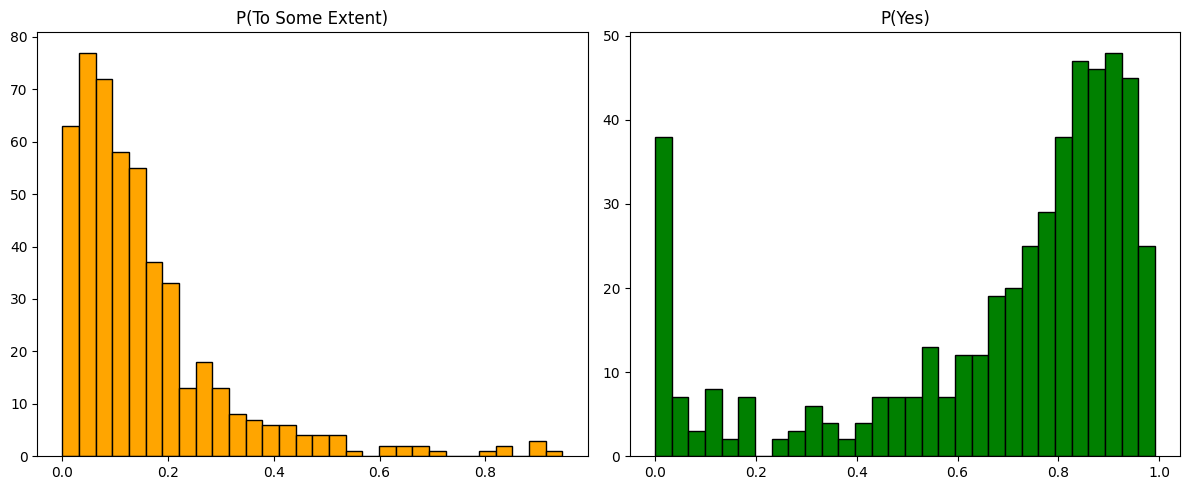

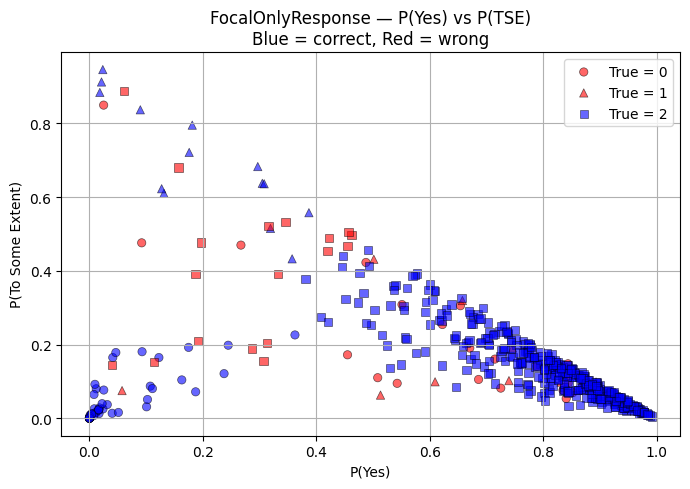

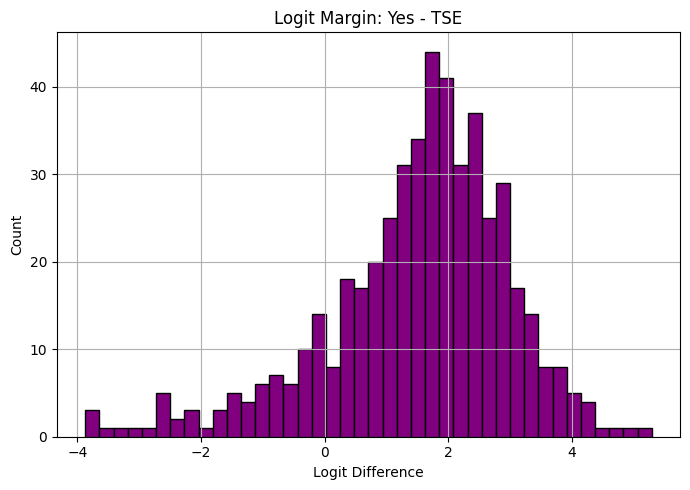

In [71]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import classification_report, f1_score, confusion_matrix

def get_logits_probs(model, dataset, batch_size=16):
    model.eval()
    model.to("cuda" if torch.cuda.is_available() else "cpu")
    all_logits = []
    all_labels = []

    with torch.no_grad():
        for i in range(0, len(dataset), batch_size):
            batch = dataset[i:i + batch_size]
            input_ids = torch.tensor(batch["input_ids"]).to(model.device)
            attention_mask = torch.tensor(batch["attention_mask"]).to(model.device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits.cpu().numpy()
            all_logits.append(logits)
            all_labels.extend(batch["labels"])

    logits = np.concatenate(all_logits)
    probs = F.softmax(torch.tensor(logits), dim=-1).numpy()
    return logits, probs, np.array(all_labels)

# Helper: histogram of class confidence
def plot_probs_hist(probs):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.hist(probs[:, 1], bins=30, color='orange', edgecolor='black')
    plt.title("P(To Some Extent)")

    plt.subplot(1, 2, 2)
    plt.hist(probs[:, 2], bins=30, color='green', edgecolor='black')
    plt.title("P(Yes)")

    plt.tight_layout()
    plt.show()

# Helper: scatter P(Yes) vs P(TSE) with correctness
def plot_confidence_scatter(probs, labels, model_name="Model"):
    preds = np.argmax(probs, axis=1)
    correct = preds == labels
    markers = {0: 'o', 1: '^', 2: 's'}
    colors = ['blue' if c else 'red' for c in correct]

    plt.figure(figsize=(7,5))
    for cls in [0, 1, 2]:
        idx = np.where(labels == cls)[0]
        plt.scatter(probs[idx, 2], probs[idx, 1], c=np.array(colors)[idx],
                    label=f"True = {cls}", marker=markers[cls], alpha=0.6,
                    edgecolors='k', linewidths=0.5)

    plt.xlabel("P(Yes)")
    plt.ylabel("P(To Some Extent)")
    plt.title(f"{model_name} — P(Yes) vs P(TSE)\nBlue = correct, Red = wrong")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Helper: plot margin between Yes and TSE
def plot_margin_histogram(logits):
    margin = logits[:, 2] - logits[:, 1]
    plt.figure(figsize=(7, 5))
    plt.hist(margin, bins=40, color='purple', edgecolor='black')
    plt.title("Logit Margin: Yes - TSE")
    plt.xlabel("Logit Difference")
    plt.ylabel("Count")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Trigger all plotting helpers using current model and validation set
logits, probs, labels = get_logits_probs(trainer.model, val_ds)
plot_probs_hist(probs)
plot_confidence_scatter(probs, labels, model_name="FocalOnlyResponse")
plot_margin_histogram(logits)


In [74]:
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix

def tune_thresholds(probs, labels, tse_range=(0.2, 0.6), yes_range=(0.5, 0.95), steps=25, only_threshold=True):
    best_macro_f1 = 0
    best_config = None

    tse_thresholds = np.linspace(*tse_range, steps)
    yes_thresholds = np.linspace(*yes_range, steps)

    for t_yes in yes_thresholds:
        for t_tse in tse_thresholds:
            preds = []
            for p in probs:
                if p[2] > t_yes:
                    preds.append(2)  # Yes
                elif p[1] > t_tse:
                    preds.append(1)  # TSE
                else:
                    preds.append(0)  # No

            macro_f1 = f1_score(labels, preds, average="macro")
            if macro_f1 > best_macro_f1:
                best_macro_f1 = macro_f1
                best_config = (t_yes, t_tse, preds)

    t_yes, t_tse, best_preds = best_config

    if only_threshold:
      print(f" Best thresholds: T_yes={t_yes:.2f}, T_TSE={t_tse:.2f}")
      print(f" Macro F1: {f1_score(labels, best_preds, average='macro'):.4f}")
      print(f"\n Classification Report:\n{classification_report(labels, best_preds, target_names=['No', 'TSE', 'Yes'])}")
      print("  Confusion Matrix:\n", confusion_matrix(labels, best_preds))
      return best_preds, t_yes, t_tse
    else:
       return {
        "macro_f1": best_macro_f1,
        "preds": best_preds,
        "t_yes": t_yes,
        "t_tse": t_tse,
        "report": classification_report(labels, best_preds, target_names=["No", "TSE", "Yes"]),
        "conf_matrix": confusion_matrix(labels, best_preds)
    }


In [75]:
best_preds, t_yes, t_tse = tune_thresholds(probs, labels)

 Best thresholds: T_yes=0.50, T_TSE=0.50
 Macro F1: 0.7112

 Classification Report:
              precision    recall  f1-score   support

          No       0.66      0.74      0.70        73
         TSE       0.68      0.42      0.52        31
         Yes       0.91      0.92      0.92       389

    accuracy                           0.86       493
   macro avg       0.75      0.69      0.71       493
weighted avg       0.86      0.86      0.86       493

  Confusion Matrix:
 [[ 54   1  18]
 [  2  13  16]
 [ 26   5 358]]


In [76]:
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import torch.nn.functional as F

def softmax_temperature(logits, temperature):
    return F.softmax(torch.tensor(logits) / temperature, dim=-1).numpy()

def run_temperature_search(logits, labels, T_range=np.linspace(1.0, 3.0, 15)):
    results = []
    for T in T_range:
        probs_T = softmax_temperature(logits, T)
        tuned = tune_thresholds(probs_T, labels, only_threshold=False)
        results.append({
            "T": T,
            **tuned
        })
        print(f"T={T:.2f} → Macro F1={tuned['macro_f1']:.4f}, T_yes={tuned['t_yes']:.2f}, T_TSE={tuned['t_tse']:.2f}")
    return results
results = run_temperature_search(logits, labels)

# Find best result
best = max(results, key=lambda x: x['macro_f1'])
print("\nBest Temperature:", best["T"])
print("Macro F1:", best["macro_f1"])
print(best["report"])
print(best["conf_matrix"])

T=1.00 → Macro F1=0.7112, T_yes=0.50, T_TSE=0.50
T=1.14 → Macro F1=0.7064, T_yes=0.50, T_TSE=0.48
T=1.29 → Macro F1=0.6970, T_yes=0.50, T_TSE=0.47
T=1.43 → Macro F1=0.6903, T_yes=0.50, T_TSE=0.45
T=1.57 → Macro F1=0.6850, T_yes=0.50, T_TSE=0.48
T=1.71 → Macro F1=0.6769, T_yes=0.50, T_TSE=0.47
T=1.86 → Macro F1=0.6681, T_yes=0.50, T_TSE=0.47
T=2.00 → Macro F1=0.6504, T_yes=0.50, T_TSE=0.45
T=2.14 → Macro F1=0.6433, T_yes=0.50, T_TSE=0.45
T=2.29 → Macro F1=0.6376, T_yes=0.50, T_TSE=0.45
T=2.43 → Macro F1=0.6226, T_yes=0.50, T_TSE=0.43
T=2.57 → Macro F1=0.6134, T_yes=0.50, T_TSE=0.43
T=2.71 → Macro F1=0.6009, T_yes=0.50, T_TSE=0.43
T=2.86 → Macro F1=0.5793, T_yes=0.50, T_TSE=0.42
T=3.00 → Macro F1=0.5659, T_yes=0.50, T_TSE=0.42

Best Temperature: 1.0
Macro F1: 0.7111825203419934
              precision    recall  f1-score   support

          No       0.66      0.74      0.70        73
         TSE       0.68      0.42      0.52        31
         Yes       0.91      0.92      0.92       

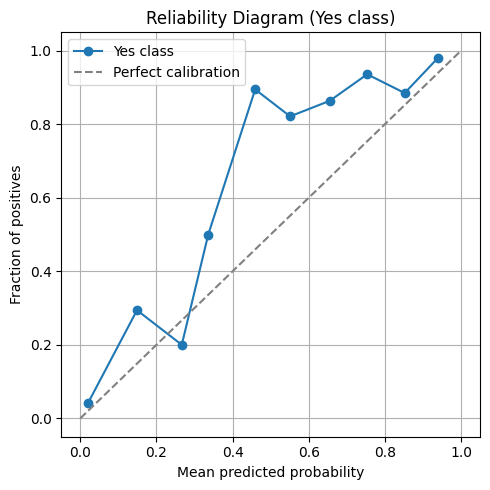

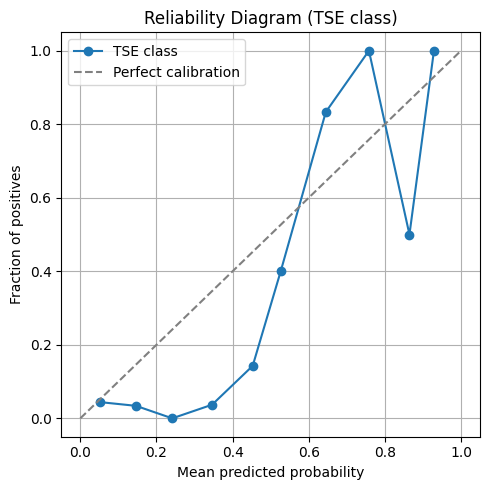

In [83]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# "Yes" class (index 2)
probs_yes = probs[:, 2]
y_true_yes = (labels == 2)

fraction_of_positives, mean_predicted_value = calibration_curve(y_true_yes, probs_yes, n_bins=10)

plt.figure(figsize=(5, 5))
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Yes class')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect calibration')
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Reliability Diagram (Yes class)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# TSE class (index 1)
probs_yes = probs[:, 1]
y_true_yes = (labels == 1)

fraction_of_positives, mean_predicted_value = calibration_curve(y_true_yes, probs_yes, n_bins=10)

plt.figure(figsize=(5, 5))
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='TSE class')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect calibration')
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Reliability Diagram (TSE class)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [86]:
from sklearn.metrics import f1_score

y_true = labels

logit_yes = logits[:, 2]
logit_tse = logits[:, 1]
logit_no = logits[:, 0]

margin = logit_yes - logit_tse

# Sweep thresholds over margin
thresholds = np.linspace(-3, 3, 100)
best_macro_f1 = -1
best_threshold = None

for tau in thresholds:
    preds = []

    for i in range(len(logits)):
        if logit_yes[i] - logit_tse[i] > tau:
            pred = 2  # Yes
        elif logit_tse[i] - logit_no[i] > tau:  # optional logic
            pred = 1  # TSE
        else:
            pred = 0  # No
        preds.append(pred)

    f1 = f1_score(y_true, preds, average="macro")
    if f1 > best_macro_f1:
        best_macro_f1 = f1
        best_threshold = tau

print(f"Best margin threshold = {best_threshold:.2f} → Macro F1 = {best_macro_f1:.4f}")


Best margin threshold = 0.33 → Macro F1 = 0.6928


Interpretare: only predict yes when you re more than 0.33 logits above TSE
still performs worst so logits are already well-calibrated and separable, margin decoding introduces unnecessary complexity without helping separability

In [90]:
batch_sizes = [8, 16, 32]
results = []
alpha=weights
gamma=1.3

for bs in batch_sizes:
    print(f"\n==> Batch size: {bs}")

    args = TrainingArguments(
        output_dir=f"./tmp-batchsize-{bs}",
        learning_rate=1e-5,
        per_device_train_batch_size=bs,
        per_device_eval_batch_size=bs,
        num_train_epochs=5,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        metric_for_best_model="eval_macro_f1",
        save_total_limit=1,
        seed=42,
        logging_dir="./logs",
        lr_scheduler_type="cosine",
        weight_decay=0.01
    )

    model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)

    trainer = CustomTrainer(
        model=model,
        args=args,
        train_dataset=train_ds_nocontext,
        eval_dataset=val_ds_nocontext,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
        loss_type="focal",
        alpha=alpha,
        gamma=gamma,
        weights=None,
        data_collator=data_collator,
    )

    trainer.train()
    metrics = trainer.evaluate()

    results.append({
        "batch_size": bs,
        "macro_f1": metrics.get("eval_macro_f1", -1),
        "lenient_f1": metrics.get("eval_lenient_f1", -1),
        "accuracy": metrics.get("eval_accuracy", -1),
        "lenient_accuracy": metrics.get("eval_lenient_accuracy", -1),
        "loss": metrics.get("eval_loss", -1)
    })

df_bs = pd.DataFrame(results)


==> Batch size: 8


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,1.228621,0.659175,0.524309,0.837117,0.956213
2,No log,2.131582,0.642230,0.674487,0.849022,0.968421
3,1.639700,4.693813,0.612261,0.648927,0.838601,0.963658
4,1.639700,5.398633,0.644519,0.691879,0.843363,0.968495
5,0.267500,5.524122,0.630057,0.674910,0.835323,0.966161


Confusion Matrix:
[[ 52  14   7]
 [  3  24   4]
 [ 13 185 191]]
              precision    recall  f1-score   support

          No       0.76      0.71      0.74        73
         TSE       0.11      0.77      0.19        31
         Yes       0.95      0.49      0.65       389

    accuracy                           0.54       493
   macro avg       0.61      0.66      0.52       493
weighted avg       0.87      0.54      0.63       493

Confusion Matrix:
[[ 52   1  20]
 [  2   8  21]
 [  4  13 372]]
              precision    recall  f1-score   support

          No       0.90      0.71      0.79        73
         TSE       0.36      0.26      0.30        31
         Yes       0.90      0.96      0.93       389

    accuracy                           0.88       493
   macro avg       0.72      0.64      0.67       493
weighted avg       0.87      0.88      0.87       493

Confusion Matrix:
[[ 51   1  21]
 [  4   5  22]
 [  5   4 380]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 51   1  21]
 [  2   8  21]
 [  3   6 380]]
              precision    recall  f1-score   support

          No       0.91      0.70      0.79        73
         TSE       0.53      0.26      0.35        31
         Yes       0.90      0.98      0.94       389

    accuracy                           0.89       493
   macro avg       0.78      0.64      0.69       493
weighted avg       0.88      0.89      0.88       493


==> Batch size: 16


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,1.254540,0.638245,0.522630,0.831458,0.956316
2,No log,1.186117,0.715470,0.642260,0.840998,0.942029
3,No log,1.826984,0.649450,0.643572,0.840395,0.953627
4,No log,3.052945,0.624529,0.641492,0.823418,0.953955
5,0.843700,3.455580,0.621488,0.650716,0.826990,0.957647


Confusion Matrix:
[[ 51  13   9]
 [  2  22   7]
 [ 13 179 197]]
              precision    recall  f1-score   support

          No       0.77      0.70      0.73        73
         TSE       0.10      0.71      0.18        31
         Yes       0.92      0.51      0.65       389

    accuracy                           0.55       493
   macro avg       0.60      0.64      0.52       493
weighted avg       0.85      0.55      0.64       493

Confusion Matrix:
[[ 55   3  15]
 [  4  18   9]
 [ 26  47 316]]
              precision    recall  f1-score   support

          No       0.65      0.75      0.70        73
         TSE       0.26      0.58      0.36        31
         Yes       0.93      0.81      0.87       389

    accuracy                           0.79       493
   macro avg       0.61      0.72      0.64       493
weighted avg       0.85      0.79      0.81       493

Confusion Matrix:
[[ 53   4  16]
 [  3  10  18]
 [ 16  23 350]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 50   2  21]
 [  3   7  21]
 [ 10   8 371]]
              precision    recall  f1-score   support

          No       0.79      0.68      0.74        73
         TSE       0.41      0.23      0.29        31
         Yes       0.90      0.95      0.93       389

    accuracy                           0.87       493
   macro avg       0.70      0.62      0.65       493
weighted avg       0.85      0.87      0.86       493


==> Batch size: 32


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,1.395666,0.582125,0.487168,0.732877,0.955631
2,No log,1.346130,0.668574,0.632219,0.806442,0.954279
3,No log,2.444401,0.601885,0.628057,0.824902,0.961404
4,No log,3.098264,0.572011,0.601133,0.799886,0.959350


Confusion Matrix:
[[ 34  26  13]
 [  0  24   7]
 [  0 192 197]]
              precision    recall  f1-score   support

          No       1.00      0.47      0.64        73
         TSE       0.10      0.77      0.18        31
         Yes       0.91      0.51      0.65       389

    accuracy                           0.52       493
   macro avg       0.67      0.58      0.49       493
weighted avg       0.87      0.52      0.62       493

Confusion Matrix:
[[ 47   5  21]
 [  3  16  12]
 [ 10  50 329]]
              precision    recall  f1-score   support

          No       0.78      0.64      0.71        73
         TSE       0.23      0.52      0.31        31
         Yes       0.91      0.85      0.88       389

    accuracy                           0.80       493
   macro avg       0.64      0.67      0.63       493
weighted avg       0.85      0.80      0.82       493

Confusion Matrix:
[[ 49   0  24]
 [  3   6  22]
 [  6  17 366]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 47   5  21]
 [  3  16  12]
 [ 10  50 329]]
              precision    recall  f1-score   support

          No       0.78      0.64      0.71        73
         TSE       0.23      0.52      0.31        31
         Yes       0.91      0.85      0.88       389

    accuracy                           0.80       493
   macro avg       0.64      0.67      0.63       493
weighted avg       0.85      0.80      0.82       493



In [91]:
df_bs

,batch_size,macro_f1,lenient_f1,accuracy,lenient_accuracy,loss
0,8,0.691879,0.968495,0.644519,0.843363,5.398633
1,16,0.650716,0.957647,0.621488,0.826990,3.455580
2,32,0.632219,0.954279,0.668574,0.806442,1.346130


In [93]:
lrs = [1e-5, 2e-5, 3e-5, 5e-5, 8e-5]
results = []

for lr in lrs:
    print(f"\n==> Learning rate: {lr}")

    args = TrainingArguments(
        output_dir="./outputs_mistake_id",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=lr,                     # smaller LR for large models
        per_device_train_batch_size=8,          
        per_device_eval_batch_size=8,
        num_train_epochs=4,                     
        weight_decay=0.01,
        load_best_model_at_end=True,
        metric_for_best_model="macro_f1",
        save_total_limit=1,
        fp16=torch.cuda.is_available(),         
        logging_dir="./logs",
        warmup_ratio=0.1,                       # important for stable training
        lr_scheduler_type=scheduler,            # "cosine"
        report_to="none",                       # disable wandb/tensorboard unless needed
        gradient_checkpointing=True,            # save memory
        seed=SEED
    )

    model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)

    trainer = CustomTrainer(
        model=model,
        args=args,
        train_dataset=train_ds_nocontext,
        eval_dataset=val_ds_nocontext,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
        loss_type=loss_type,
        alpha=alpha,
        gamma=gamma,
        weights=None  # not used in focal mode,
        data_collator=data_collator,
    )

    trainer.train()
    metrics = trainer.evaluate()

    results.append({
        "learning_rate": lr,
        "macro_f1": metrics.get("eval_macro_f1", -1),
        "lenient_f1": metrics.get("eval_lenient_f1", -1),
        "accuracy": metrics.get("eval_accuracy", -1),
        "lenient_accuracy": metrics.get("eval_lenient_accuracy", -1),
        "loss": metrics.get("eval_loss", -1)
    })

# Save and view
df_wd = pd.DataFrame(results)


==> Learning rate: 1e-05


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,1.364224,0.635570,0.511270,0.820727,0.968786
2,No log,1.756690,0.650131,0.687692,0.839791,0.964871
3,1.781900,4.272566,0.629576,0.668700,0.846347,0.959811
4,1.781900,4.135258,0.641949,0.685214,0.838601,0.963658


Confusion Matrix:
[[ 47  19   7]
 [  0  26   5]
 [  1 223 165]]
              precision    recall  f1-score   support

          No       0.98      0.64      0.78        73
         TSE       0.10      0.84      0.17        31
         Yes       0.93      0.42      0.58       389

    accuracy                           0.48       493
   macro avg       0.67      0.64      0.51       493
weighted avg       0.89      0.48      0.59       493

Confusion Matrix:
[[ 51   1  21]
 [  2   9  20]
 [  6   9 374]]
              precision    recall  f1-score   support

          No       0.86      0.70      0.77        73
         TSE       0.47      0.29      0.36        31
         Yes       0.90      0.96      0.93       389

    accuracy                           0.88       493
   macro avg       0.75      0.65      0.69       493
weighted avg       0.87      0.88      0.87       493

Confusion Matrix:
[[ 53   0  20]
 [  3   6  22]
 [ 11   1 377]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 51   1  21]
 [  2   9  20]
 [  6   9 374]]
              precision    recall  f1-score   support

          No       0.86      0.70      0.77        73
         TSE       0.47      0.29      0.36        31
         Yes       0.90      0.96      0.93       389

    accuracy                           0.88       493
   macro avg       0.75      0.65      0.69       493
weighted avg       0.87      0.88      0.87       493


==> Learning rate: 2e-05


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,1.278135,0.665677,0.574823,0.822815,0.965116
2,No log,1.690489,0.690184,0.692596,0.840982,0.966082
3,1.792300,4.184755,0.654497,0.670078,0.859752,0.955795
4,1.792300,5.032417,0.676202,0.710095,0.847831,0.967213


Confusion Matrix:
[[ 48  10  15]
 [  1  22   8]
 [  4 140 245]]
              precision    recall  f1-score   support

          No       0.91      0.66      0.76        73
         TSE       0.13      0.71      0.22        31
         Yes       0.91      0.63      0.75       389

    accuracy                           0.64       493
   macro avg       0.65      0.67      0.57       493
weighted avg       0.86      0.64      0.71       493

Confusion Matrix:
[[ 51   3  19]
 [  1  14  16]
 [  6  25 358]]
              precision    recall  f1-score   support

          No       0.88      0.70      0.78        73
         TSE       0.33      0.45      0.38        31
         Yes       0.91      0.92      0.92       389

    accuracy                           0.86       493
   macro avg       0.71      0.69      0.69       493
weighted avg       0.87      0.86      0.86       493

Confusion Matrix:
[[ 56   1  16]
 [  4   8  19]
 [ 16   8 365]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 52   3  18]
 [  1  11  19]
 [  6   9 374]]
              precision    recall  f1-score   support

          No       0.88      0.71      0.79        73
         TSE       0.48      0.35      0.41        31
         Yes       0.91      0.96      0.94       389

    accuracy                           0.89       493
   macro avg       0.76      0.68      0.71       493
weighted avg       0.88      0.89      0.88       493


==> Learning rate: 3e-05


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,1.242072,0.680138,0.568925,0.837720,0.944712
2,No log,1.722169,0.678574,0.684008,0.844553,0.969697
3,1.762200,4.582390,0.648792,0.671575,0.848434,0.956005
4,1.762200,5.861004,0.646233,0.692464,0.840982,0.966082


Confusion Matrix:
[[ 54   8  11]
 [  5  20   6]
 [ 22 112 255]]
              precision    recall  f1-score   support

          No       0.67      0.74      0.70        73
         TSE       0.14      0.65      0.23        31
         Yes       0.94      0.66      0.77       389

    accuracy                           0.67       493
   macro avg       0.58      0.68      0.57       493
weighted avg       0.85      0.67      0.73       493

Confusion Matrix:
[[ 51   3  19]
 [  1  13  17]
 [  3  29 357]]
              precision    recall  f1-score   support

          No       0.93      0.70      0.80        73
         TSE       0.29      0.42      0.34        31
         Yes       0.91      0.92      0.91       389

    accuracy                           0.85       493
   macro avg       0.71      0.68      0.68       493
weighted avg       0.87      0.85      0.86       493

Confusion Matrix:
[[ 54   2  17]
 [  4   8  19]
 [ 14   6 369]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 51   2  20]
 [  4   8  19]
 [  3   4 382]]
              precision    recall  f1-score   support

          No       0.88      0.70      0.78        73
         TSE       0.57      0.26      0.36        31
         Yes       0.91      0.98      0.94       389

    accuracy                           0.89       493
   macro avg       0.79      0.65      0.69       493
weighted avg       0.88      0.89      0.88       493


==> Learning rate: 5e-05


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,1.600584,0.523735,0.386059,0.784442,0.891688
2,No log,1.663885,0.668198,0.652272,0.822521,0.958968
3,2.223600,2.569646,0.605313,0.630536,0.812997,0.949112
4,2.223600,2.340597,0.643182,0.665813,0.826093,0.962617


Confusion Matrix:
[[ 53  16   4]
 [ 10  16   5]
 [ 56 205 128]]
              precision    recall  f1-score   support

          No       0.45      0.73      0.55        73
         TSE       0.07      0.52      0.12        31
         Yes       0.93      0.33      0.49       389

    accuracy                           0.40       493
   macro avg       0.48      0.52      0.39       493
weighted avg       0.81      0.40      0.47       493

Confusion Matrix:
[[ 49   5  19]
 [  1  14  16]
 [ 10  36 343]]
              precision    recall  f1-score   support

          No       0.82      0.67      0.74        73
         TSE       0.25      0.45      0.33        31
         Yes       0.91      0.88      0.89       389

    accuracy                           0.82       493
   macro avg       0.66      0.67      0.65       493
weighted avg       0.85      0.82      0.84       493

Confusion Matrix:
[[ 49   2  22]
 [  5   6  20]
 [ 14   5 370]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 49   2  22]
 [  1  10  20]
 [  7  18 364]]
              precision    recall  f1-score   support

          No       0.86      0.67      0.75        73
         TSE       0.33      0.32      0.33        31
         Yes       0.90      0.94      0.92       389

    accuracy                           0.86       493
   macro avg       0.70      0.64      0.67       493
weighted avg       0.86      0.86      0.85       493


==> Learning rate: 8e-05


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,1.334617,0.659029,0.598332,0.832094,0.892308
2,No log,1.664150,0.674571,0.664196,0.841879,0.961131
3,1.966700,3.141931,0.636901,0.664321,0.847538,0.961039
4,1.966700,4.291720,0.629201,0.670617,0.834132,0.964953


Confusion Matrix:
[[ 61   3   9]
 [  7  11  13]
 [ 65  18 306]]
              precision    recall  f1-score   support

          No       0.46      0.84      0.59        73
         TSE       0.34      0.35      0.35        31
         Yes       0.93      0.79      0.85       389

    accuracy                           0.77       493
   macro avg       0.58      0.66      0.60       493
weighted avg       0.83      0.77      0.78       493

Confusion Matrix:
[[ 52   2  19]
 [  2  13  16]
 [ 10  32 347]]
              precision    recall  f1-score   support

          No       0.81      0.71      0.76        73
         TSE       0.28      0.42      0.33        31
         Yes       0.91      0.89      0.90       389

    accuracy                           0.84       493
   macro avg       0.67      0.67      0.66       493
weighted avg       0.85      0.84      0.84       493

Confusion Matrix:
[[ 53   1  19]
 [  5   7  19]
 [  8   8 373]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 50   2  21]
 [  4   7  20]
 [  3   6 380]]
              precision    recall  f1-score   support

          No       0.88      0.68      0.77        73
         TSE       0.47      0.23      0.30        31
         Yes       0.90      0.98      0.94       389

    accuracy                           0.89       493
   macro avg       0.75      0.63      0.67       493
weighted avg       0.87      0.89      0.87       493



In [94]:
df_wd # care de fapt e df_lr

,learning_rate,macro_f1,lenient_f1,accuracy,lenient_accuracy,loss
0,0.00001,0.687692,0.964871,0.650131,0.839791,1.756690
1,0.00002,0.710095,0.967213,0.676202,0.847831,5.032417
2,0.00003,0.692464,0.966082,0.646233,0.840982,5.861004
3,0.00005,0.665813,0.962617,0.643182,0.826093,2.340597
4,0.00008,0.670617,0.964953,0.629201,0.834132,4.291720


In [95]:
weight_decays = [0.0, 0.01, 0.03, 0.05, 0.1, 0.2]  # values to sweep
learning_rate = 2e-5
results = []

for wd in weight_decays:
    print(f"\n==> Weight Decay: {wd}")

    args = TrainingArguments(
        output_dir="./outputs_mistake_id",
        eval_strategy="epoch",
        save_strategy="epoch",
        learning_rate=learning_rate,                    
        per_device_train_batch_size=8,          
        per_device_eval_batch_size=8,
        num_train_epochs=4,                     
        weight_decay=wd,
        load_best_model_at_end=True,
        metric_for_best_model="macro_f1",
        save_total_limit=1,
        fp16=torch.cuda.is_available(),         # mixed precision helps on A100s
        logging_dir="./logs",
        warmup_ratio=0.1,                       # important for stable training
        lr_scheduler_type=scheduler,            # "cosine"
        report_to="none",                       # disable wandb/tensorboard unless needed
        # gradient_accumulation_steps=2,        # effectively increase batch size
        gradient_checkpointing=True,            # save memory
        seed=SEED
    )

    model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)

    trainer = CustomTrainer(
        model=model,
        args=args,
        train_dataset=train_ds_nocontext,
        eval_dataset=val_ds_nocontext,
        compute_metrics=compute_metrics,
        callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
        loss_type=loss_type,
        alpha=alpha,
        gamma=gamma,
        weights=None  # not used in focal mode,
        data_collator=data_collator,
    )

    trainer.train()
    metrics = trainer.evaluate()

    results.append({
        "weight_decay": wd,
        "macro_f1": metrics.get("eval_macro_f1", -1),
        "lenient_f1": metrics.get("eval_lenient_f1", -1),
        "accuracy": metrics.get("eval_accuracy", -1),
        "lenient_accuracy": metrics.get("eval_lenient_accuracy", -1),
        "loss": metrics.get("eval_loss", -1)
    })

df_wd_real = pd.DataFrame(results)


==> Weight Decay: 0.0


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,1.313453,0.625366,0.582715,0.774870,0.957324
2,No log,1.772589,0.670204,0.690261,0.843069,0.962353
3,1.809800,4.636361,0.630903,0.648992,0.839204,0.952381
4,1.809800,5.567865,0.639378,0.672808,0.838601,0.963658


Confusion Matrix:
[[ 41  11  21]
 [  2  17  12]
 [  3  88 298]]
              precision    recall  f1-score   support

          No       0.89      0.56      0.69        73
         TSE       0.15      0.55      0.23        31
         Yes       0.90      0.77      0.83       389

    accuracy                           0.72       493
   macro avg       0.65      0.63      0.58       493
weighted avg       0.85      0.72      0.77       493

Confusion Matrix:
[[ 52   3  18]
 [  2  11  18]
 [  9  13 367]]
              precision    recall  f1-score   support

          No       0.83      0.71      0.76        73
         TSE       0.41      0.35      0.38        31
         Yes       0.91      0.94      0.93       389

    accuracy                           0.87       493
   macro avg       0.71      0.67      0.69       493
weighted avg       0.87      0.87      0.87       493

Confusion Matrix:
[[ 53   1  19]
 [  5   7  19]
 [ 15   8 366]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 52   3  18]
 [  2  11  18]
 [  9  13 367]]
              precision    recall  f1-score   support

          No       0.83      0.71      0.76        73
         TSE       0.41      0.35      0.38        31
         Yes       0.91      0.94      0.93       389

    accuracy                           0.87       493
   macro avg       0.71      0.67      0.69       493
weighted avg       0.87      0.87      0.87       493


==> Weight Decay: 0.01


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,1.278135,0.665677,0.574823,0.822815,0.965116
2,No log,1.824734,0.691898,0.697291,0.842172,0.967290
3,1.779700,4.541216,0.633755,0.648277,0.850815,0.958482
4,1.779700,5.796321,0.647278,0.689475,0.834132,0.964953


Confusion Matrix:
[[ 48  10  15]
 [  1  22   8]
 [  4 140 245]]
              precision    recall  f1-score   support

          No       0.91      0.66      0.76        73
         TSE       0.13      0.71      0.22        31
         Yes       0.91      0.63      0.75       389

    accuracy                           0.64       493
   macro avg       0.65      0.67      0.57       493
weighted avg       0.86      0.64      0.71       493

Confusion Matrix:
[[ 51   3  19]
 [  1  14  16]
 [  5  24 360]]
              precision    recall  f1-score   support

          No       0.89      0.70      0.78        73
         TSE       0.34      0.45      0.39        31
         Yes       0.91      0.93      0.92       389

    accuracy                           0.86       493
   macro avg       0.72      0.69      0.70       493
weighted avg       0.87      0.86      0.87       493

Confusion Matrix:
[[ 54   2  17]
 [  3   7  21]
 [ 13  12 364]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 51   3  19]
 [  1  14  16]
 [  5  24 360]]
              precision    recall  f1-score   support

          No       0.89      0.70      0.78        73
         TSE       0.34      0.45      0.39        31
         Yes       0.91      0.93      0.92       389

    accuracy                           0.86       493
   macro avg       0.72      0.69      0.70       493
weighted avg       0.87      0.86      0.87       493


==> Weight Decay: 0.03


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,1.157985,0.681006,0.591868,0.847847,0.943168
2,No log,1.834051,0.679243,0.698600,0.841879,0.961131
3,1.801900,4.403090,0.662397,0.684396,0.860046,0.962085
4,1.801900,5.388133,0.664593,0.697745,0.845450,0.964789


Confusion Matrix:
[[ 56   5  12]
 [  4  17  10]
 [ 26  80 283]]
              precision    recall  f1-score   support

          No       0.65      0.77      0.70        73
         TSE       0.17      0.55      0.26        31
         Yes       0.93      0.73      0.82       389

    accuracy                           0.72       493
   macro avg       0.58      0.68      0.59       493
weighted avg       0.84      0.72      0.76       493

Confusion Matrix:
[[ 52   2  19]
 [  1  12  18]
 [ 11  13 365]]
              precision    recall  f1-score   support

          No       0.81      0.71      0.76        73
         TSE       0.44      0.39      0.41        31
         Yes       0.91      0.94      0.92       389

    accuracy                           0.87       493
   macro avg       0.72      0.68      0.70       493
weighted avg       0.86      0.87      0.87       493

Confusion Matrix:
[[ 55   1  17]
 [  2   9  20]
 [ 12  10 367]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 52   2  19]
 [  1  12  18]
 [ 11  13 365]]
              precision    recall  f1-score   support

          No       0.81      0.71      0.76        73
         TSE       0.44      0.39      0.41        31
         Yes       0.91      0.94      0.92       389

    accuracy                           0.87       493
   macro avg       0.72      0.68      0.70       493
weighted avg       0.86      0.87      0.87       493


==> Weight Decay: 0.05


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,1.243035,0.669608,0.618302,0.824902,0.961404
2,No log,1.913282,0.704551,0.719511,0.861236,0.963314
3,1.721400,4.982339,0.669441,0.689463,0.852006,0.959716
4,1.721400,6.439277,0.651845,0.688964,0.840982,0.966082


Confusion Matrix:
[[ 49   8  16]
 [  3  17  11]
 [  6  76 307]]
              precision    recall  f1-score   support

          No       0.84      0.67      0.75        73
         TSE       0.17      0.55      0.26        31
         Yes       0.92      0.79      0.85       389

    accuracy                           0.76       493
   macro avg       0.64      0.67      0.62       493
weighted avg       0.86      0.76      0.80       493

Confusion Matrix:
[[ 55   1  17]
 [  3  13  15]
 [ 10  13 366]]
              precision    recall  f1-score   support

          No       0.81      0.75      0.78        73
         TSE       0.48      0.42      0.45        31
         Yes       0.92      0.94      0.93       389

    accuracy                           0.88       493
   macro avg       0.74      0.70      0.72       493
weighted avg       0.88      0.88      0.88       493

Confusion Matrix:
[[ 54   1  18]
 [  5  10  16]
 [ 10  11 368]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 55   1  17]
 [  3  13  15]
 [ 10  13 366]]
              precision    recall  f1-score   support

          No       0.81      0.75      0.78        73
         TSE       0.48      0.42      0.45        31
         Yes       0.92      0.94      0.93       389

    accuracy                           0.88       493
   macro avg       0.74      0.70      0.72       493
weighted avg       0.88      0.88      0.88       493


==> Weight Decay: 0.1


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,1.319722,0.619744,0.563870,0.763552,0.957520
2,No log,1.616585,0.690853,0.708795,0.841879,0.961131
3,1.919900,3.589147,0.603692,0.625016,0.831458,0.956316
4,1.919900,4.929782,0.623202,0.658725,0.829371,0.960094


Confusion Matrix:
[[ 39  13  21]
 [  1  19  11]
 [  2 110 277]]
              precision    recall  f1-score   support

          No       0.93      0.53      0.68        73
         TSE       0.13      0.61      0.22        31
         Yes       0.90      0.71      0.79       389

    accuracy                           0.68       493
   macro avg       0.65      0.62      0.56       493
weighted avg       0.85      0.68      0.74       493

Confusion Matrix:
[[ 52   2  19]
 [  2  13  16]
 [ 10  13 366]]
              precision    recall  f1-score   support

          No       0.81      0.71      0.76        73
         TSE       0.46      0.42      0.44        31
         Yes       0.91      0.94      0.93       389

    accuracy                           0.87       493
   macro avg       0.73      0.69      0.71       493
weighted avg       0.87      0.87      0.87       493

Confusion Matrix:
[[ 51   2  20]
 [  4   5  22]
 [ 11   8 370]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 52   2  19]
 [  2  13  16]
 [ 10  13 366]]
              precision    recall  f1-score   support

          No       0.81      0.71      0.76        73
         TSE       0.46      0.42      0.44        31
         Yes       0.91      0.94      0.93       389

    accuracy                           0.87       493
   macro avg       0.73      0.69      0.71       493
weighted avg       0.87      0.87      0.87       493


==> Weight Decay: 0.2


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Accuracy,Macro F1,Lenient Accuracy,Lenient F1
1,No log,1.272875,0.621728,0.563423,0.792140,0.963134
2,No log,1.978231,0.674958,0.687670,0.832355,0.951249
3,1.756600,4.567638,0.620150,0.637338,0.842776,0.956109
4,1.756600,5.307308,0.599983,0.625305,0.830561,0.961313


Confusion Matrix:
[[ 43  14  16]
 [  1  19  11]
 [  1 130 258]]
              precision    recall  f1-score   support

          No       0.96      0.59      0.73        73
         TSE       0.12      0.61      0.20        31
         Yes       0.91      0.66      0.77       389

    accuracy                           0.65       493
   macro avg       0.66      0.62      0.56       493
weighted avg       0.86      0.65      0.72       493

Confusion Matrix:
[[ 52   2  19]
 [  2  12  17]
 [ 18  11 360]]
              precision    recall  f1-score   support

          No       0.72      0.71      0.72        73
         TSE       0.48      0.39      0.43        31
         Yes       0.91      0.93      0.92       389

    accuracy                           0.86       493
   macro avg       0.70      0.67      0.69       493
weighted avg       0.85      0.86      0.86       493

Confusion Matrix:
[[ 53   1  19]
 [  4   6  21]
 [ 13  10 366]]
              precision    recall  f1-score   

Confusion Matrix:
[[ 52   2  19]
 [  2  12  17]
 [ 18  11 360]]
              precision    recall  f1-score   support

          No       0.72      0.71      0.72        73
         TSE       0.48      0.39      0.43        31
         Yes       0.91      0.93      0.92       389

    accuracy                           0.86       493
   macro avg       0.70      0.67      0.69       493
weighted avg       0.85      0.86      0.86       493



In [96]:
df_wd_real

,weight_decay,macro_f1,lenient_f1,accuracy,lenient_accuracy,loss
0,0.00,0.690261,0.962353,0.670204,0.843069,1.772589
1,0.01,0.697291,0.967290,0.691898,0.842172,1.824734
2,0.03,0.698600,0.961131,0.679243,0.841879,1.834051
3,0.05,0.719511,0.963314,0.704551,0.861236,1.913282
4,0.10,0.708795,0.961131,0.690853,0.841879,1.616585
5,0.20,0.687670,0.951249,0.674958,0.832355,1.978231


In [32]:
from collections import Counter
import torch

def get_class_balanced_alpha():
    class_counts = [Counter(train_df["mistake_identification"])[i] for i in range(3)]
    
    # Inverse frequency alpha (manual)
    inv_freq_alpha = torch.tensor([1 / c for c in class_counts])
    inv_freq_alpha = inv_freq_alpha / inv_freq_alpha.sum() * len(class_counts)
    
    # Class-balanced alpha (Cui et al., 2019)
    def compute_cb_alpha(class_counts, beta):
        counts = torch.tensor(class_counts).float()
        effective_num = 1.0 - torch.pow(beta, counts)
        alpha_cb = (1.0 - beta) / effective_num
        alpha_cb = alpha_cb / alpha_cb.sum() * len(class_counts)  # normalize
        return alpha_cb
    
    cb_alpha = compute_cb_alpha(class_counts, beta=0.999)
    return cb_alpha

cb_alpha = get_class_balanced_alpha()
cb_alpha

tensor([0.9216, 1.7772, 0.3012])

In [ ]:
from transformers import AutoModelForSequenceClassification
from transformers import EarlyStoppingCallback
import numpy as np, random, pandas as pd

loss_variants = [
    ("Focal_InvFreq", weights_normalized),
    ("Focal_CB", cb_alpha),
]

results = []

for name, alpha in loss_variants:
        print(f"\n==> Loss: {name}")
        args = TrainingArguments(
            output_dir="./outputs_mistake_id",
            eval_strategy="epoch",
            save_strategy="epoch",
            learning_rate=learning_rate,                    
            per_device_train_batch_size=8,          
            per_device_eval_batch_size=8,
            num_train_epochs=4,                     
            weight_decay=0.05,
            load_best_model_at_end=True,
            metric_for_best_model="macro_f1",
            save_total_limit=1,
            fp16=torch.cuda.is_available(),         # mixed precision helps on A100s
            logging_dir="./logs",
            warmup_ratio=0.1,                       # important for stable training
            lr_scheduler_type=scheduler,            # "cosine"
            report_to="none",                       # disable wandb/tensorboard unless needed
            # gradient_accumulation_steps=2,        # effectively increase batch size
            gradient_checkpointing=True,            # save memory
            seed=SEED
        )

        model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)

        trainer = CustomTrainer(
            model=model,
            args=args,  # your predefined TrainingArguments
            train_dataset=train_ds_nocontext,
            eval_dataset=val_ds_nocontext,
            compute_metrics=compute_metrics,
            callbacks=[EarlyStoppingCallback(early_stopping_patience=2)],
            loss_type="focal",
            alpha=alpha,
            gamma=1.3,
            weights=None,  # unused for focal loss,
            data_collator=data_collator,
        )

        trainer.train()
        metrics = trainer.evaluate()

        results.append({
            "loss_variant": name,
            "macro_f1": metrics.get("eval_macro_f1", -1),
            "lenient_f1": metrics.get("eval_lenient_f1", -1),
            "accuracy": metrics.get("eval_accuracy", -1),
            "lenient_accuracy": metrics.get("eval_lenient_accuracy", -1),
            "loss": metrics.get("eval_loss", -1)
        })

df_focal_compare = pd.DataFrame(results)

In [102]:
df_focal_compare

,loss_variant,macro_f1,lenient_f1,accuracy,lenient_accuracy,loss
0,Focal_InvFreq,0.691041,0.962353,0.677529,0.843069,0.226618
1,Focal_CB,0.706478,0.969697,0.656129,0.844553,0.259856


/tmp/ipykernel_1468704/3983799568.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  input_ids = torch.tensor(batch["input_ids"]).to(model.device)
/tmp/ipykernel_1468704/3983799568.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  attention_mask = torch.tensor(batch["attention_mask"]).to(model.device)


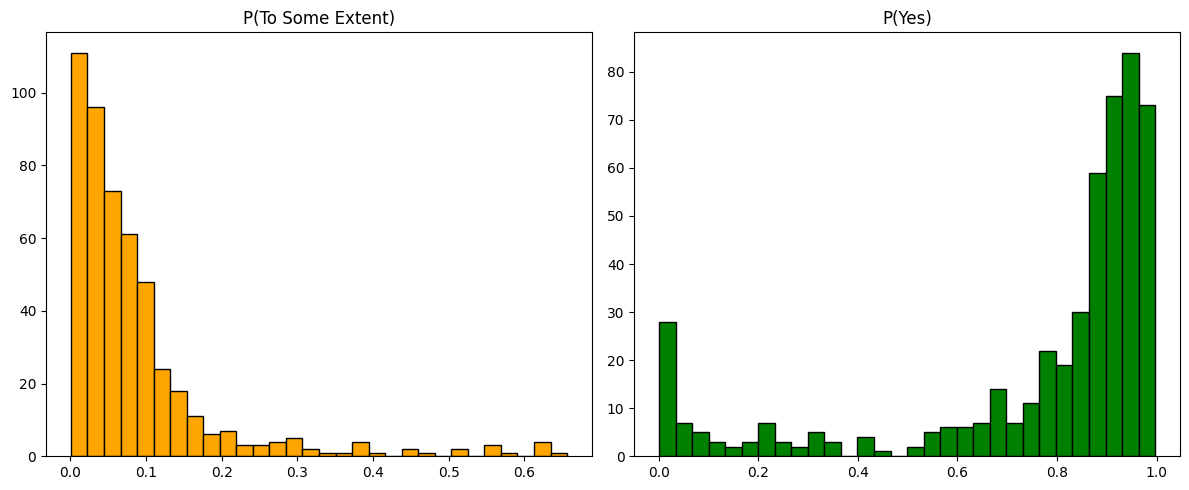

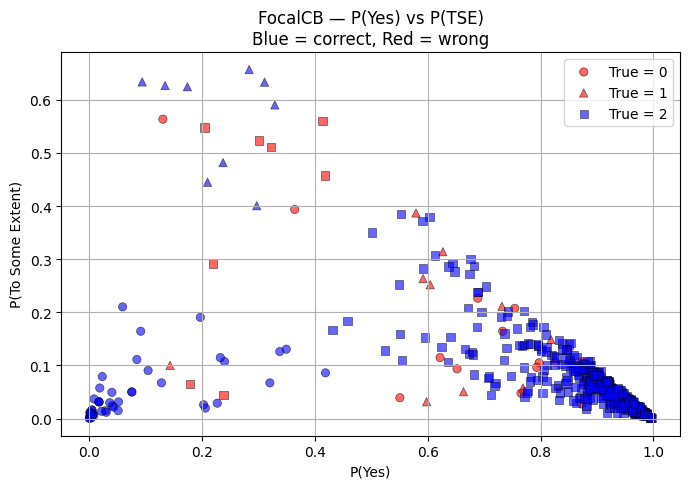

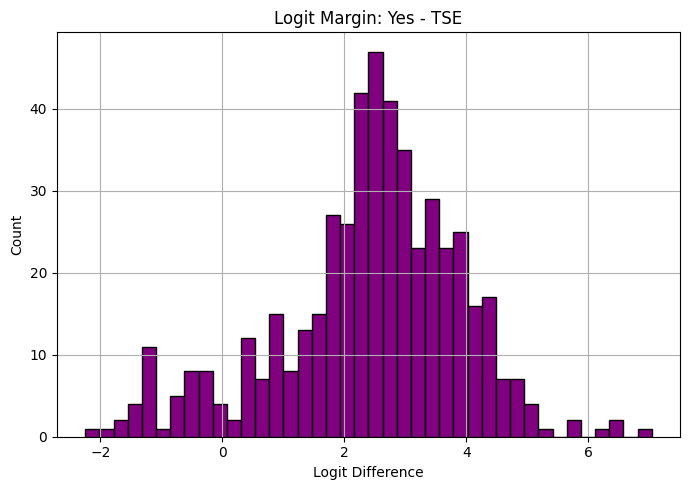

In [103]:
logits, probs, labels = get_logits_probs(trainer.model, val_ds)
plot_probs_hist(probs)
plot_confidence_scatter(probs, labels, model_name="FocalCB")
plot_margin_histogram(logits)

In [104]:
best_preds, t_yes, t_tse = tune_thresholds(probs, labels)

 Best thresholds: T_yes=0.63, T_TSE=0.22
 Macro F1: 0.7145

 Classification Report:
              precision    recall  f1-score   support

          No       0.83      0.73      0.77        73
         TSE       0.46      0.42      0.44        31
         Yes       0.92      0.94      0.93       389

    accuracy                           0.88       493
   macro avg       0.74      0.70      0.71       493
weighted avg       0.87      0.88      0.88       493

  Confusion Matrix:
 [[ 53   2  18]
 [  2  13  16]
 [  9  13 367]]


In [105]:
results = run_temperature_search(logits, labels)

# Find best result
best = max(results, key=lambda x: x['macro_f1'])
print("\nBest Temperature:", best["T"])
print("Macro F1:", best["macro_f1"])
print(best["report"])
print(best["conf_matrix"])

T=1.00 → Macro F1=0.7145, T_yes=0.63, T_TSE=0.22
T=1.14 → Macro F1=0.7114, T_yes=0.57, T_TSE=0.23
T=1.29 → Macro F1=0.7114, T_yes=0.56, T_TSE=0.25
T=1.43 → Macro F1=0.7121, T_yes=0.54, T_TSE=0.28
T=1.57 → Macro F1=0.7145, T_yes=0.52, T_TSE=0.28
T=1.71 → Macro F1=0.7045, T_yes=0.50, T_TSE=0.28
T=1.86 → Macro F1=0.7018, T_yes=0.50, T_TSE=0.27
T=2.00 → Macro F1=0.7139, T_yes=0.50, T_TSE=0.30
T=2.14 → Macro F1=0.6942, T_yes=0.50, T_TSE=0.30
T=2.29 → Macro F1=0.6716, T_yes=0.50, T_TSE=0.30
T=2.43 → Macro F1=0.6675, T_yes=0.50, T_TSE=0.30
T=2.57 → Macro F1=0.6517, T_yes=0.50, T_TSE=0.30
T=2.71 → Macro F1=0.6494, T_yes=0.50, T_TSE=0.30
T=2.86 → Macro F1=0.6394, T_yes=0.50, T_TSE=0.30
T=3.00 → Macro F1=0.6352, T_yes=0.50, T_TSE=0.30

Best Temperature: 1.0
Macro F1: 0.714504839296518
              precision    recall  f1-score   support

          No       0.83      0.73      0.77        73
         TSE       0.46      0.42      0.44        31
         Yes       0.92      0.94      0.93       3

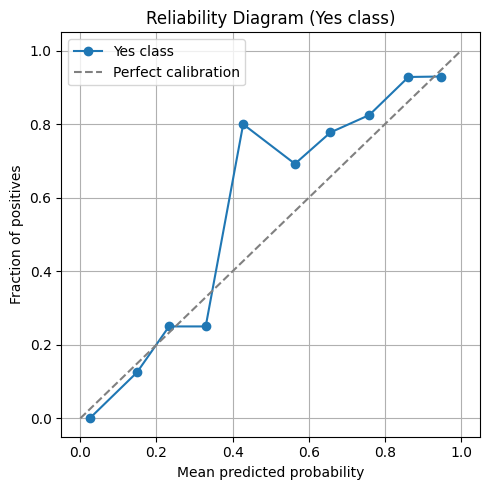

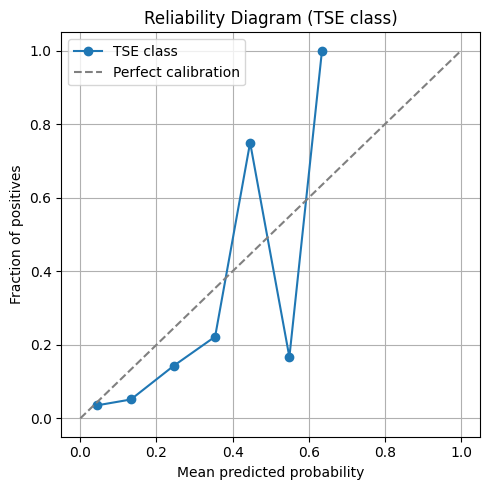

In [109]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# "Yes" class (index 2)
probs_yes = probs[:, 2]
y_true_yes = (labels == 2)

fraction_of_positives, mean_predicted_value = calibration_curve(y_true_yes, probs_yes, n_bins=10)

plt.figure(figsize=(5, 5))
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Yes class')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect calibration')
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Reliability Diagram (Yes class)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# TSE class (index 1)
probs_yes = probs[:, 1]
y_true_yes = (labels == 1)

fraction_of_positives, mean_predicted_value = calibration_curve(y_true_yes, probs_yes, n_bins=10)

plt.figure(figsize=(5, 5))
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='TSE class')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfect calibration')
plt.xlabel("Mean predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Reliability Diagram (TSE class)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [112]:
import os
import json
import numpy as np

os.makedirs("checkpoints_full_dev", exist_ok=True)
os.makedirs("logits_dev_phase", exist_ok=True)

os.makedirs("logits_test_phase", exist_ok=True)

In [113]:
full_df["labels"] = full_df["mistake_identification"]
full_ds = Dataset.from_pandas(full_df[["last_student_turn", "response", "labels"]])
full_ds = full_ds.map(tokenize_no_context, batched=True)

Map: 100% 2476/2476 [00:00<00:00, 5628.57 examples/s]


In [114]:
test_df = pd.read_csv("data/test_df.csv")
test_ds = Dataset.from_pandas(test_df[["last_student_turn", "response"]])
test_ds = test_ds.map(tokenize_no_context, batched=True)

Map: 100% 1547/1547 [00:00<00:00, 5274.69 examples/s]



 Training model for 2 epochs


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.294000



 Evaluation for 2 epochs:
              precision    recall  f1-score   support

          No       0.94      0.72      0.82       370
         TSE       0.55      0.60      0.58       174
         Yes       0.94      0.97      0.95      1932

    accuracy                           0.91      2476
   macro avg       0.81      0.76      0.78      2476
weighted avg       0.91      0.91      0.91      2476



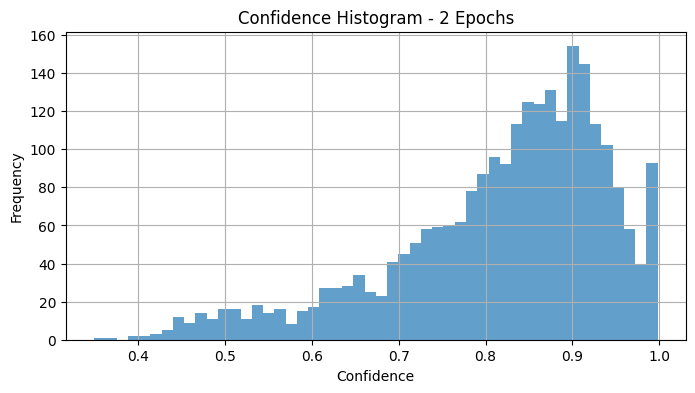

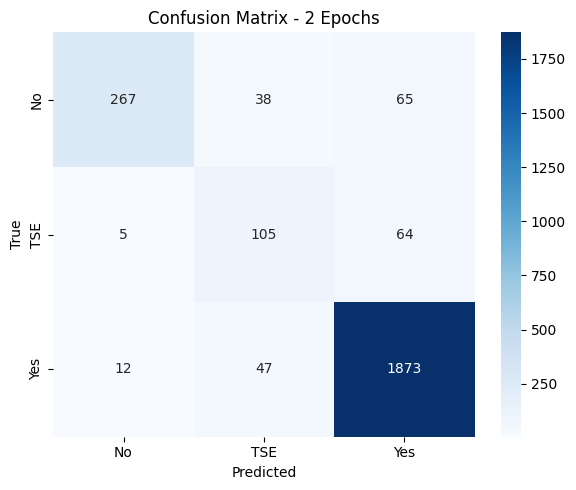


 Training model for 3 epochs


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.252400



 Evaluation for 3 epochs:
              precision    recall  f1-score   support

          No       0.99      0.96      0.98       370
         TSE       0.94      0.97      0.95       174
         Yes       0.99      1.00      0.99      1932

    accuracy                           0.99      2476
   macro avg       0.97      0.98      0.98      2476
weighted avg       0.99      0.99      0.99      2476



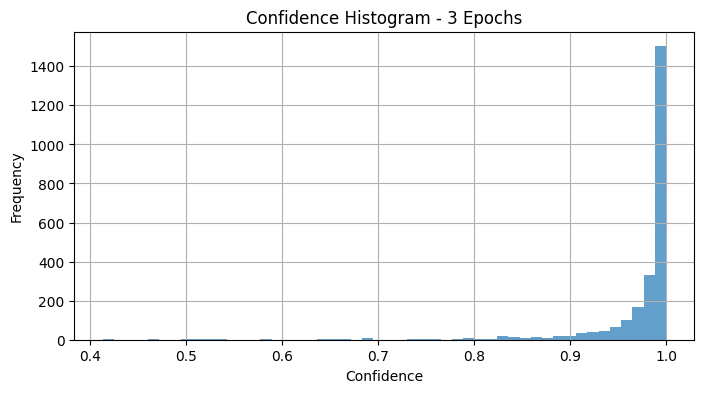

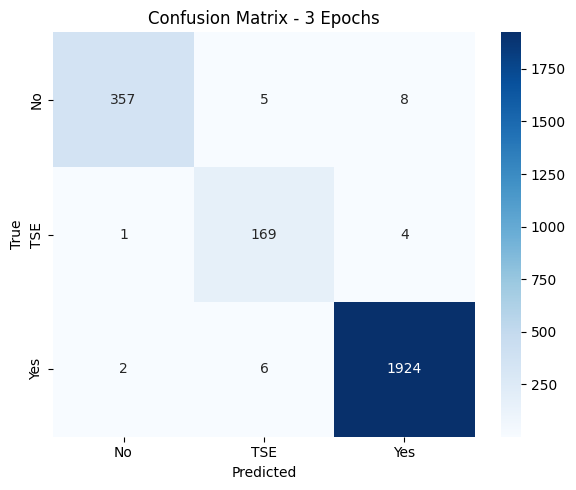


 Training model for 4 epochs


Some weights of ModernBertForSequenceClassification were not initialized from the model checkpoint at answerdotai/ModernBERT-large and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss
500,0.258800
1000,0.069300



 Evaluation for 4 epochs:
              precision    recall  f1-score   support

          No       1.00      0.98      0.99       370
         TSE       0.95      0.99      0.97       174
         Yes       1.00      1.00      1.00      1932

    accuracy                           1.00      2476
   macro avg       0.98      0.99      0.99      2476
weighted avg       1.00      1.00      1.00      2476



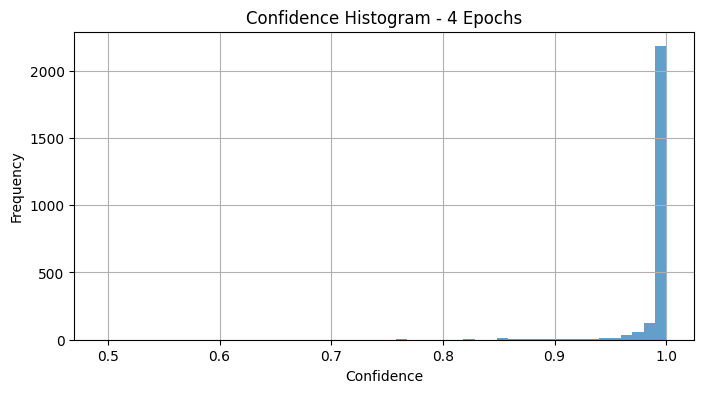

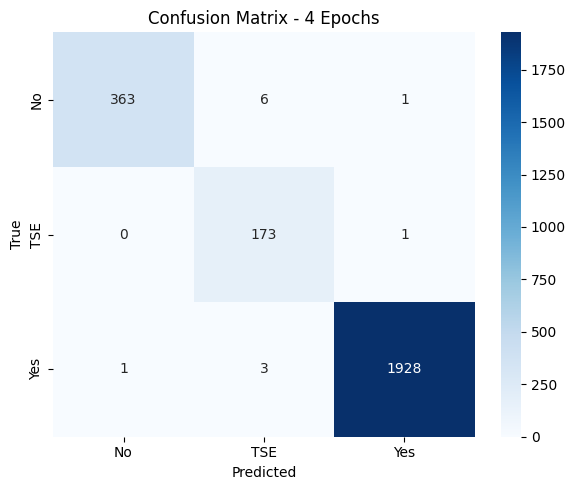

In [115]:
import os
import numpy as np
from transformers import TrainingArguments, EarlyStoppingCallback, set_seed
from transformers import RobertaForSequenceClassification
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import torch

num_labels = 3
epochs_to_compare = [2, 3, 4]
temperature = 1
threshold_yes = 0.63
threshold_tse = 0.22

for num_epochs in epochs_to_compare:
    test_logits_list = []
    dev_logits_list = []

    print(f"\n Training model for {num_epochs} epochs")

    training_args = TrainingArguments(
        output_dir=f"checkpoints_full_dev/{num_epochs}epochs",
        eval_strategy="no",
        save_strategy="no",
        learning_rate=learning_rate,                    
        per_device_train_batch_size=8,          
        per_device_eval_batch_size=8,
        num_train_epochs=num_epochs,                   
        weight_decay=0.05,
        load_best_model_at_end=False,
        save_total_limit=1,
        fp16=torch.cuda.is_available(),         # mixed precision helps on A100s
        logging_dir="./logs",
        warmup_ratio=0.1,                       # important for stable training
        lr_scheduler_type=scheduler,            # "cosine"
        report_to="none",                       # disable wandb/tensorboard unless needed
        # gradient_accumulation_steps=2,        # effectively increase batch size
        gradient_checkpointing=True,            # save memory
        seed=SEED
        )

    model = AutoModelForSequenceClassification.from_pretrained(MODEL, num_labels=3)

    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=full_ds,
        eval_dataset=None,
        compute_metrics=None,
        loss_type="focal",
        alpha=cb_alpha,
        gamma=1.3,
        weights=None,
        data_collator=data_collator,
    )

    trainer.train()

    # Predict on test and full devset
    test_output = trainer.predict(test_ds)
    test_logits = test_output.predictions
    test_logits_list.append(test_logits)
    np.save(f"logits_test_phase/test_logits_{num_epochs}epochs.npy", test_logits)

    dev_output = trainer.predict(full_ds)
    dev_logits = dev_output.predictions
    dev_logits_list.append(dev_logits)
    np.save(f"logits_dev_phase/dev_logits_{num_epochs}epochs.npy", dev_logits)

    # Apply temperature scaling
    logits_tensor = torch.tensor(dev_logits) / temperature
    probs = torch.nn.functional.softmax(logits_tensor, dim=-1).numpy()

    # Thresholded predictions
    final_preds = []
    for p in probs:
        if p[2] > threshold_yes:
            final_preds.append(2)
        elif p[1] > threshold_tse:
            final_preds.append(1)
        else:
            final_preds.append(np.argmax(p))

    # Ground truth labels
    true_labels = np.array(full_ds["labels"])

    # Print metrics
    print(f"\n Evaluation for {num_epochs} epochs:")
    print(classification_report(true_labels, final_preds, target_names=["No", "TSE", "Yes"]))

    # Plot confidence histogram
    confidences = probs.max(axis=1)
    plt.figure(figsize=(8, 4))
    plt.hist(confidences, bins=50, alpha=0.7)
    plt.title(f"Confidence Histogram - {num_epochs} Epochs")
    plt.xlabel("Confidence")
    plt.ylabel("Frequency")
    plt.grid(True)
    plt.show()

    # Save confusion matrix
    cm = confusion_matrix(true_labels, final_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No", "TSE", "Yes"], yticklabels=["No", "TSE", "Yes"])
    plt.title(f"Confusion Matrix - {num_epochs} Epochs")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.tight_layout()
    plt.show()


In [121]:
logits_list = []
num_epochs=3
path = f"logits_test_phase/test_logits_{num_epochs}epochs.npy"
logits = np.load(path)

scaled_logits = logits / temperature
probs = np.exp(scaled_logits) / np.sum(np.exp(scaled_logits), axis=1, keepdims=True)

# Predict with thresholds
final_preds_test = []
for p in probs:
    if p[2] > threshold_yes:
        final_preds_test.append("Yes")
    elif p[1] > threshold_tse:
        final_preds_test.append("To some extent")
    else:
        final_preds_test.append("No")

final_preds_test[:8]  # Show a few predictions to verify format

['Yes', 'Yes', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'Yes']

In [122]:
import json

with open("data/testset.json", "r") as f:
    test_data = json.load(f)

flattened_responses = []
for item in test_data:
    for tutor_id, tutor_entry in item["tutor_responses"].items():
        flattened_responses.append({
            "conversation_id": item["conversation_id"],
            "conversation_history": item["conversation_history"],
            "tutor": tutor_id,
            "response": tutor_entry["response"]
        })

print("Total testset entries:", len(test_data))
print("Total tutor responses in testset:", len(flattened_responses))
print("Total predictions:", len(final_preds_test))

Total testset entries: 191
Total tutor responses in testset: 1547
Total predictions: 1547


In [123]:
idx = 0
for entry in test_data:
    for tutor_id in entry["tutor_responses"]:
        prediction = final_preds_test[idx]
        entry["tutor_responses"][tutor_id]["annotation"] = {
            "Mistake_Identification": prediction
        }
        idx += 1

In [124]:
with open("predictions3epochs.json", "w") as f:
    json.dump(test_data, f, indent=2)

In [161]:
import os
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

In [156]:
torch.cuda.empty_cache()

In [ ]:
# === Find top 3 configs
# === Train final models on training set and predict on val set, if happy make on full dataset and predict on test ===
final_models = []
for i, cfg in enumerate(top_configs):
    args = TrainingArguments(
        output_dir=f"./final/model_{i}",
        learning_rate=cfg["lr"],
        per_device_train_batch_size=cfg["bs"],
        per_device_eval_batch_size=cfg["bs"],
        num_train_epochs=cfg["epochs"],
        evaluation_strategy="no",
        seed=seeds[0]
    )
    trainer = Trainer(
        model_init=model_init,
        args=args,
        train_dataset=train_ds_nocontext,
        tokenizer=tokenizer
    )
    trainer.train()
    final_models.append(trainer.model)

# === 3) Ensemble predictions with optional temperature scaling ===
def ensemble_predict(models, dataset, temperature=1.0):
    all_logits = []
    for model in models:
        trainer.model = model
        preds = trainer.predict(dataset)
        logits = preds.predictions / temperature
        all_logits.append(logits)
    mean_logits = np.mean(all_logits, axis=0)
    probs = torch.softmax(torch.tensor(mean_logits), dim=-1).numpy()
    preds = np.argmax(probs, axis=-1)
    return preds, probs

# on validation set
val_preds, val_probs = ensemble_predict(final_models, val_ds_nocontext)

# === 4) Threshold / Temperature Tuning (outline) ===
# You can now tune a global temperature or per-class thresholds 
# on val_probs vs val_labels to maximize macro_f1, then 
# apply to test set with `ensemble_predict(models, test_ds, best_temp)`.


In [1]:
import os
print(os.getpid())

2258236
